In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from itertools import combinations
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Initialization

In [2]:
PROJECT_NAMES = ["1_1_affirming_opposing_light", "1_opposing_affirming_claims ", "2_Sequential-Claims-Hard",
                 "3_reactiveness", "4_different_depths", "4_1_different_depths_light", "5_claim_path_density"]

MODEL_GROUPS = {
    'GPT': ['gpt2'],
    'BERT': ['bert-base-uncased', 'facebook/bart-base', 'albert-base-v2'],
    'ELECTRA': ['microsoft/deberta-v3-base']
}

METRICS = ["full test f1"]
CONTROL_TASKS = ["RANDOMIZATION", "NONE", "PERMUTATION"]
MODELS = ['microsoft/deberta-v3-base', 'facebook/bart-base', 'gpt2', 'albert-base-v2', 'bert-base-uncased']
SEEDS = [0, 1, 2, 3, 4]
FOLDS = [0, 1, 2, 3]

In [3]:
# Load datasets
context_df = pd.read_csv('../probing_results/wandb_data_2.csv')
no_context_df = pd.read_csv('../probing_results//wandb_no_context_runs.csv')

In [4]:
# Project name mapping
project_name_mapping = {
    "1_1_affirming_opposing_light": "1_5 Stance Alignment Task Light",
    "1_opposing_affirming_claims": "1 Stance Alignment Task",
    "2_Sequential-Claims-Hard": "2 Sequential Coherence Task",
    "3_reactiveness": "3 Interactive Dynamics Task",
    "4_different_depths": "4 Claim Depth Hierarchy Task",
    "4_1_different_depths_light": "4_5 Claim Depth Hierarchy Task Light",
    "5_claim_path_density": "5 Discussion Contour Recognition Task"
}

# No-context project name mapping
no_context_project_name_mapping = {
    "probe_1_no_context": "1 Stance Alignment Task - No Context",
    "probe_2_no_context": "2 Sequential Coherence Task - No Context",
    "probe_3_no_context": "3 Interactive Dynamics Task - No Context",
    "probe_4_no_context": "4 Claim Depth Hierarchy Task - No Context",
    "probe_5_no_context": "5 Discussion Contour Recognition Task - No Context"
}

# Apply project name mapping
context_df['project'] = context_df['project'].map(project_name_mapping)
no_context_df['project'] = no_context_df['project'].map(no_context_project_name_mapping)

# Constants
MODELS = ['microsoft/deberta-v3-base', 'facebook/bart-base', 'gpt2', 'albert-base-v2', 'bert-base-uncased']
CONTEXT_TASKS = list(project_name_mapping.values())
NO_CONTEXT_TASKS = list(no_context_project_name_mapping.values())


In [5]:
# Group by project and model, then aggregate by median for each control task
grouped_f1_none = context_df[context_df['control_task'] == 'NONE'].groupby(['project', 'model'])[
    'value'].median().reset_index()
grouped_f1_randomization = context_df[context_df['control_task'] == 'RANDOMIZATION'].groupby(['project', 'model'])[
    'value'].median().reset_index()
grouped_f1_permutation = context_df[context_df['control_task'] == 'PERMUTATION'].groupby(['project', 'model'])[
    'value'].median().reset_index()

# Control Task Rankings

## Selectivity Ranking

In [6]:
PROJECT_NAMES_NEW = [
    "1 Stance Alignment",
    "1_5 Stance Alignment light",
    "2 Sequential Coherence",
    "3 Interactive Dynamics",
    "4 Claim Depth Hierarchy",
    "4_5 Claim Depth Hierarchy light",
    "5 Discourse Contour Recognition"
]

In [7]:
# Calculate normalized differences for Selectivity and Permutation rankings
selectivity_diff = (grouped_f1_none.set_index(['project', 'model']) - grouped_f1_randomization.set_index(
    ['project', 'model'])) / (grouped_f1_none.set_index(['project', 'model']) + grouped_f1_randomization.set_index(
    ['project', 'model']))
# Reset index and add 'rank' column for each ranking
selectivity_ranking = selectivity_diff.reset_index()
selectivity_ranking['rank'] = selectivity_ranking.groupby('project')['value'].rank(ascending=False)



In [8]:
selectivity_ranking[["project", "model", 'rank']]

,project,model,rank
0,1 Stance Alignment Task,albert-base-v2,3.0
1,1 Stance Alignment Task,bert-base-uncased,1.0
2,1 Stance Alignment Task,facebook/bart-base,5.0
3,1 Stance Alignment Task,gpt2,2.0
4,1 Stance Alignment Task,microsoft/deberta-v3-base,4.0
5,1_5 Stance Alignment Task Light,albert-base-v2,4.0
6,1_5 Stance Alignment Task Light,bert-base-uncased,3.0
7,1_5 Stance Alignment Task Light,facebook/bart-base,2.0
8,1_5 Stance Alignment Task Light,gpt2,5.0
9,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,1.0


In [9]:
selectivity_ranking

,project,model,value,rank
0,1 Stance Alignment Task,albert-base-v2,0.009340,3.0
1,1 Stance Alignment Task,bert-base-uncased,0.016582,1.0
2,1 Stance Alignment Task,facebook/bart-base,0.006541,5.0
3,1 Stance Alignment Task,gpt2,0.011740,2.0
4,1 Stance Alignment Task,microsoft/deberta-v3-base,0.007565,4.0
5,1_5 Stance Alignment Task Light,albert-base-v2,0.116691,4.0
6,1_5 Stance Alignment Task Light,bert-base-uncased,0.117457,3.0
7,1_5 Stance Alignment Task Light,facebook/bart-base,0.128680,2.0
8,1_5 Stance Alignment Task Light,gpt2,0.116136,5.0
9,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,0.146546,1.0


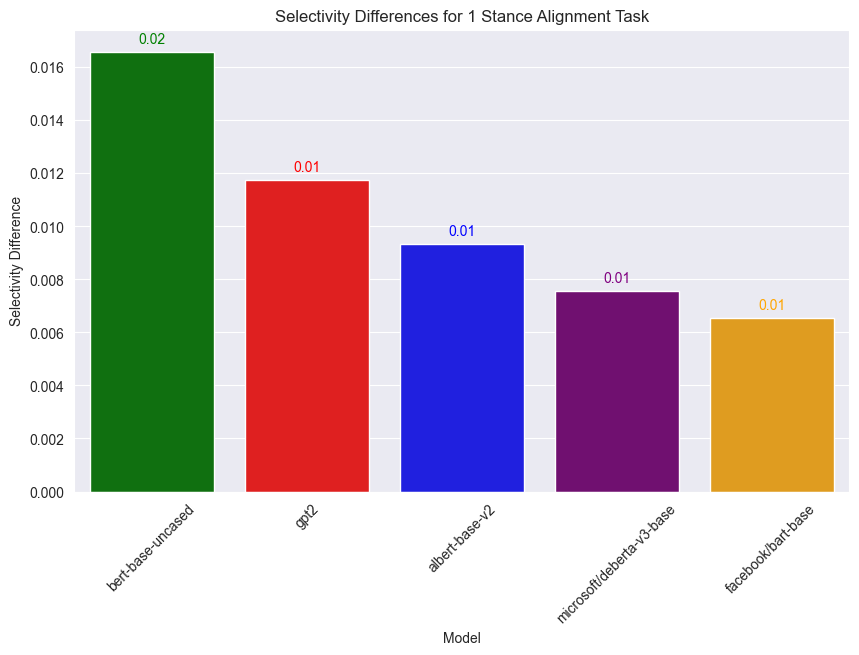

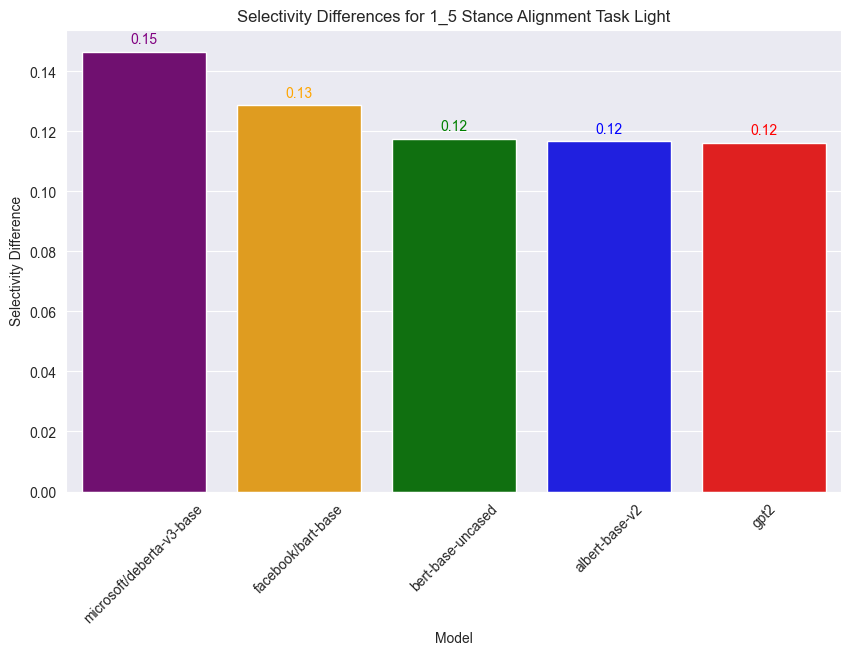

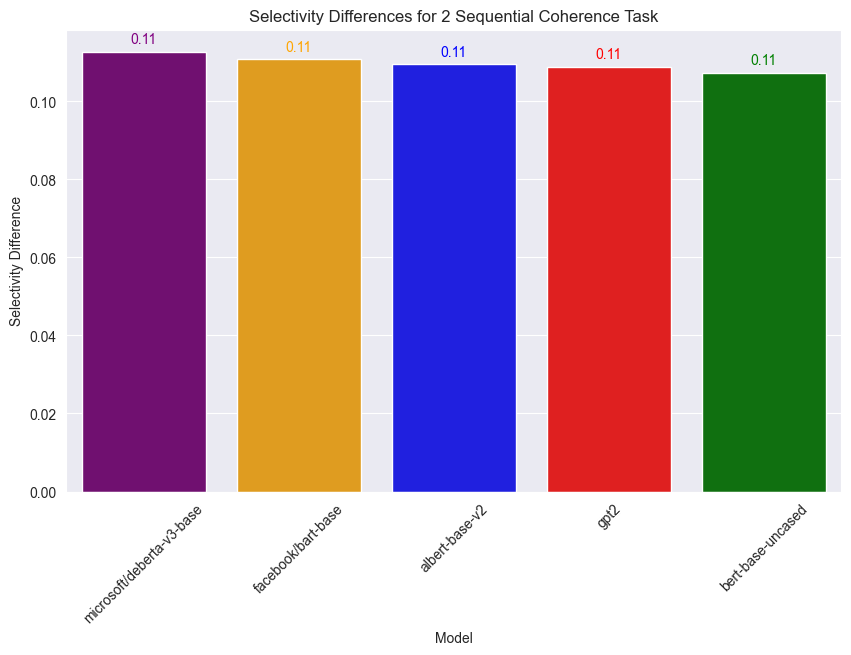

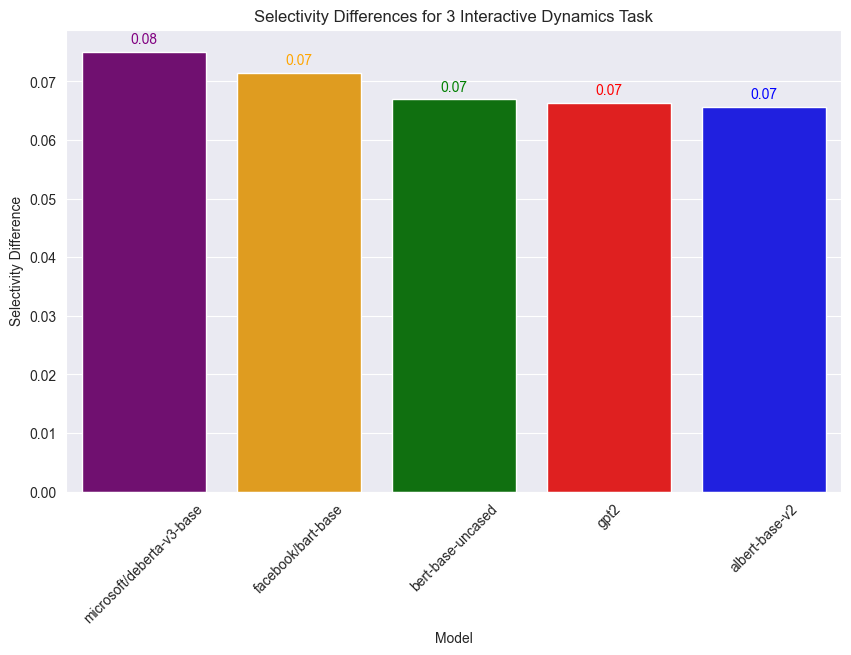

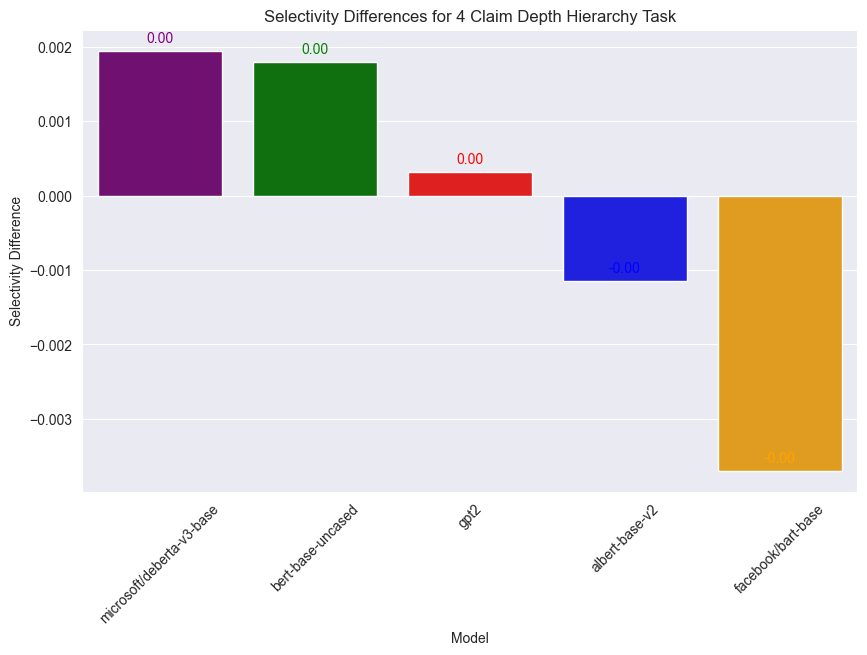

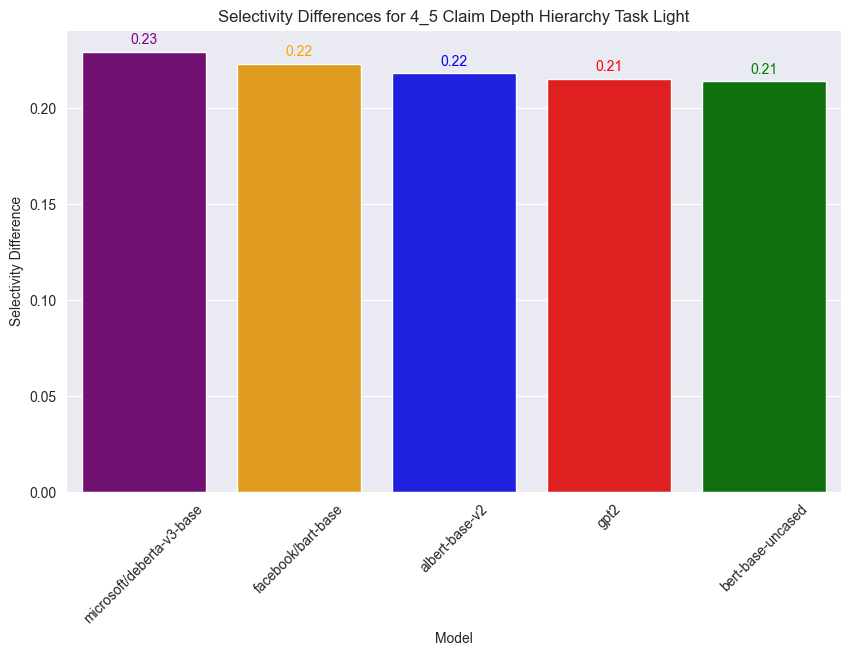

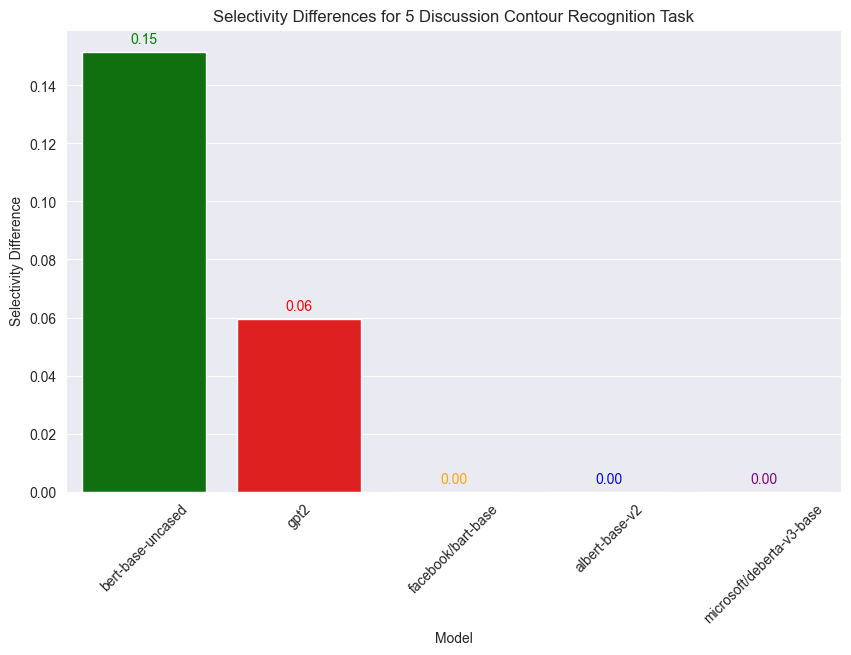

In [159]:
def print_selectivity_ranking(dataframe):
    # Print the selectivity ranking DataFrame
    print(dataframe[['project', 'model', 'rank']])


def plot_selectivity(dataframe, project_name, model_colors):
    # Filter the data for the specified project
    project_data = dataframe[dataframe['project'] == project_name]

    # Sort the models based on the selectivity differences
    sorted_data = project_data.sort_values(by='value', ascending=False)

    # Get the colors for each model
    colors = sorted_data['model'].map(model_colors).tolist()

    # Generate the bar plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='model', y='value', data=sorted_data, palette=colors)
    plt.title(f'Selectivity Differences for {project_name}')
    plt.xticks(rotation=45)
    plt.ylabel('Selectivity Difference')
    plt.xlabel('Model')

    # Add the bar values as annotations
    for p, color in zip(barplot.patches, colors):
        barplot.annotate(format(p.get_height(), '.2f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points',
                         color=color)

    plt.show()


# Mock model colors
model_colors = {
    'albert-base-v2': 'blue',
    'bert-base-uncased': 'green',
    'facebook/bart-base': 'orange',
    'gpt2': 'red',
    'microsoft/deberta-v3-base': 'purple'
}

projects = selectivity_ranking['project'].unique()

for project in projects:
    plot_selectivity(selectivity_ranking, project, model_colors)

## Permutation Ranking

In [160]:

permutation_diff = (grouped_f1_none.set_index(['project', 'model']) - grouped_f1_permutation.set_index(
    ['project', 'model'])) / (grouped_f1_none.set_index(['project', 'model']) + grouped_f1_permutation.set_index(
    ['project', 'model']))
permutation_ranking = permutation_diff.reset_index()
permutation_ranking['rank'] = permutation_ranking.groupby('project')['value'].rank(ascending=False)

In [161]:
permutation_ranking[["project", "model", 'rank']]

,project,model,rank
0,1 Stance Alignment Task,albert-base-v2,5.0
1,1 Stance Alignment Task,bert-base-uncased,1.0
2,1 Stance Alignment Task,facebook/bart-base,4.0
3,1 Stance Alignment Task,gpt2,3.0
4,1 Stance Alignment Task,microsoft/deberta-v3-base,2.0
5,1_5 Stance Alignment Task Light,albert-base-v2,2.0
6,1_5 Stance Alignment Task Light,bert-base-uncased,4.0
7,1_5 Stance Alignment Task Light,facebook/bart-base,3.0
8,1_5 Stance Alignment Task Light,gpt2,5.0
9,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,1.0


# No Context Ranking

In [162]:
# Extracting the project number
context_df['project_number'] = context_df['project'].str.extract(r'(\d+)')
no_context_df['project_number'] = no_context_df['project'].str.extract(r'(\d+) .* - No Context')
# Aggregate F1 scores for each model and project number in both datasets
context_agg_filtered = \
context_df[(context_df['control_task'] == 'NONE') & (context_df['metric'] == 'full test f1')].groupby(
    ['project_number', 'model'])['value'].median().reset_index()
no_context_agg_filtered = \
no_context_df[(no_context_df['control_task'] == 'NONE') & (no_context_df['metric'] == 'full test f1')].groupby(
    ['project_number', 'model'])['value'].median().reset_index()


In [163]:
# Merge the aggregated dataframes based on project number and model
merged_df_filtered = pd.merge(context_agg_filtered, no_context_agg_filtered, on=['project_number', 'model'],
                              suffixes=('_context', '_no_context'))

# Calculate normalized performance difference
merged_df_filtered['performance_diff'] = merged_df_filtered['value_no_context'] - merged_df_filtered['value_context']
merged_df_filtered['normalized_performance_diff'] = merged_df_filtered['performance_diff'] / (
            merged_df_filtered['value_no_context'] + merged_df_filtered['value_context'])

# Group by model and project number and calculate the median of performance differences
grouped_no_context_df = merged_df_filtered.groupby(['model', 'project_number'])[
    'normalized_performance_diff'].median().reset_index()
grouped_no_context_df['rank'] = grouped_no_context_df.groupby('project_number')['normalized_performance_diff'].rank(
    ascending=False)


In [164]:
grouped_no_context_df

,model,project_number,normalized_performance_diff,rank
0,albert-base-v2,1,-0.110943,2.0
1,albert-base-v2,2,0.006261,1.0
2,albert-base-v2,3,-0.006656,2.0
3,albert-base-v2,4,-0.219956,1.0
4,albert-base-v2,5,0.001688,2.0
5,bert-base-uncased,1,-0.124002,4.0
6,bert-base-uncased,2,0.005607,2.0
7,bert-base-uncased,3,-0.006989,4.0
8,bert-base-uncased,4,-0.226220,2.0
9,bert-base-uncased,5,-0.000002,4.0


In [165]:
grouped_no_context_df[["project_number", "model", 'rank']]

,project_number,model,rank
0,1,albert-base-v2,2.0
1,2,albert-base-v2,1.0
2,3,albert-base-v2,2.0
3,4,albert-base-v2,1.0
4,5,albert-base-v2,2.0
5,1,bert-base-uncased,4.0
6,2,bert-base-uncased,2.0
7,3,bert-base-uncased,4.0
8,4,bert-base-uncased,2.0
9,5,bert-base-uncased,4.0


In [166]:
context_df

,project,model,seed,fold,control_task,metric,value,project_number
0,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,1,3,PERMUTATION,full test f1,0.597360,1
1,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,1,3,PERMUTATION,full test acc,0.599378,1
2,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,4,2,PERMUTATION,full test f1,0.598910,1
3,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,4,2,PERMUTATION,full test acc,0.600488,1
4,1_5 Stance Alignment Task Light,microsoft/deberta-v3-base,4,3,PERMUTATION,full test f1,0.599023,1
...,...,...,...,...,...,...,...,...
15137,5 Discussion Contour Recognition Task,bert-base-uncased,0,1,NONE,full test acc,0.403120,5
15138,5 Discussion Contour Recognition Task,bert-base-uncased,0,0,NONE,full test f1,0.374284,5
15139,5 Discussion Contour Recognition Task,bert-base-uncased,0,0,NONE,full test acc,0.396560,5
15140,5 Discussion Contour Recognition Task,bert-base-uncased,2,0,NONE,full test f1,0.373250,5


# Robustness Rankings

In [167]:
# Function to perform ANOVA and calculate p-values for robustness
def perform_anova(data, fixed_factor, variable_factor, task):
    results = {}
    for model in MODELS:
        model_data = data[(data['model'] == model) & (data['project'] == task)]
        if not model_data.empty:
            formula = f'value ~ C({fixed_factor}) + C({variable_factor})'
            model_anova = ols(formula, data=model_data).fit()
            anova_results = sm.stats.anova_lm(model_anova, typ=2)
            results[model] = anova_results['PR(>F)'][f'C({variable_factor})']
    return results


# ANOVA for varying seed (fixing fold)
anova_results_seeds = {}
for task in CONTEXT_TASKS:
    seed_results = perform_anova(context_df, 'fold', 'seed', task)
    anova_results_seeds[task] = seed_results

# ANOVA for varying fold (fixing seed)
anova_results_folds = {}
for task in CONTEXT_TASKS:
    fold_results = perform_anova(context_df, 'seed', 'fold', task)
    anova_results_folds[task] = fold_results

anova_results_seeds, anova_results_folds

({'1_5 Stance Alignment Task Light': {'microsoft/deberta-v3-base': 0.9927990686576976,
   'facebook/bart-base': 0.8956915157259344,
   'gpt2': 0.8978358048038838,
   'albert-base-v2': 0.9711106774814527,
   'bert-base-uncased': 0.664576053778853},
  '1 Stance Alignment Task': {'microsoft/deberta-v3-base': 0.48160546921530634,
   'facebook/bart-base': 0.029047525320623883,
   'gpt2': 0.9329678360057599,
   'albert-base-v2': 0.34659011838773157,
   'bert-base-uncased': 0.04570341673874489},
  '2 Sequential Coherence Task': {'microsoft/deberta-v3-base': 0.9973059302070801,
   'facebook/bart-base': 0.990357722573308,
   'gpt2': 0.906204765794698,
   'albert-base-v2': 0.9968795521267313,
   'bert-base-uncased': 0.9409117593743022},
  '3 Interactive Dynamics Task': {'microsoft/deberta-v3-base': 0.9999998575110515,
   'facebook/bart-base': 0.9999993936947864,
   'gpt2': 0.9999996626124353,
   'albert-base-v2': 0.9999995270984616,
   'bert-base-uncased': 0.9999999606837422},
  '4 Claim Depth H

In [114]:
# Function to create a DataFrame from ANOVA results for ranking
def create_ranking_df_from_anova(anova_results):
    ranking_data = []
    for task, task_results in anova_results.items():
        task_row = []
        for model in MODELS:
            p_value = task_results.get(model, np.nan)
            task_row.append(p_value)
        ranking_data.append(task_row)

    ranking_df = pd.DataFrame(ranking_data, index=CONTEXT_TASKS, columns=MODELS)
    return ranking_df


# Create DataFrames for seed and fold variability rankings
seed_ranking_df = create_ranking_df_from_anova(anova_results_seeds)
fold_ranking_df = create_ranking_df_from_anova(anova_results_folds)

seed_ranking_df, fold_ranking_df

(                                       microsoft/deberta-v3-base  \
 1_5 Stance Alignment Task Light                         0.992799   
 1 Stance Alignment Task                                 0.481605   
 2 Sequential Coherence Task                             0.997306   
 3 Interactive Dynamics Task                             1.000000   
 4 Claim Depth Hierarchy Task                            0.780054   
 4_5 Claim Depth Hierarchy Task Light                    0.994518   
 5 Discussion Contour Recognition Task                   0.997880   
 
                                        facebook/bart-base      gpt2  \
 1_5 Stance Alignment Task Light                  0.895692  0.897836   
 1 Stance Alignment Task                          0.029048  0.932968   
 2 Sequential Coherence Task                      0.990358  0.906205   
 3 Interactive Dynamics Task                      0.999999  1.000000   
 4 Claim Depth Hierarchy Task                     0.000117  0.051425   
 4_5 Claim Dep

In [115]:
seed_ranking_df_sorted = seed_ranking_df.apply(lambda x: x.rank(method='min', ascending=False), axis=1)
seed_ranking_df_sorted

,microsoft/deberta-v3-base,facebook/bart-base,gpt2,albert-base-v2,bert-base-uncased
1_5 Stance Alignment Task Light,1.0,4.0,3.0,2.0,5.0
1 Stance Alignment Task,2.0,5.0,1.0,3.0,4.0
2 Sequential Coherence Task,1.0,3.0,5.0,2.0,4.0
3 Interactive Dynamics Task,2.0,5.0,3.0,4.0,1.0
4 Claim Depth Hierarchy Task,1.0,5.0,2.0,3.0,4.0
4_5 Claim Depth Hierarchy Task Light,1.0,5.0,2.0,3.0,4.0
5 Discussion Contour Recognition Task,1.0,2.0,5.0,3.0,4.0


In [116]:
fold_ranking_df_sorted = fold_ranking_df.apply(lambda x: x.rank(method='min', ascending=False), axis=1)
fold_ranking_df_sorted

,microsoft/deberta-v3-base,facebook/bart-base,gpt2,albert-base-v2,bert-base-uncased
1_5 Stance Alignment Task Light,2.0,1.0,5.0,4.0,3.0
1 Stance Alignment Task,3.0,5.0,2.0,4.0,1.0
2 Sequential Coherence Task,4.0,3.0,5.0,2.0,1.0
3 Interactive Dynamics Task,3.0,5.0,4.0,2.0,1.0
4 Claim Depth Hierarchy Task,1.0,4.0,5.0,2.0,3.0
4_5 Claim Depth Hierarchy Task Light,4.0,1.0,2.0,5.0,3.0
5 Discussion Contour Recognition Task,5.0,3.0,1.0,4.0,2.0


In [117]:
# Average the ranks across the seed and fold DataFrames
average_ranking = (seed_ranking_df_sorted + fold_ranking_df_sorted) / 2

# Sort the average ranks within each task
average_ranking_sorted = average_ranking.apply(lambda x: x.sort_values())


In [118]:
average_ranking_sorted

,microsoft/deberta-v3-base,facebook/bart-base,gpt2,albert-base-v2,bert-base-uncased
1 Stance Alignment Task,2.5,5.0,1.5,3.5,2.5
1_5 Stance Alignment Task Light,1.5,2.5,4.0,3.0,4.0
2 Sequential Coherence Task,2.5,3.0,5.0,2.0,2.5
3 Interactive Dynamics Task,2.5,5.0,3.5,3.0,1.0
4 Claim Depth Hierarchy Task,1.0,4.5,3.5,2.5,3.5
4_5 Claim Depth Hierarchy Task Light,2.5,3.0,2.0,4.0,3.5
5 Discussion Contour Recognition Task,3.0,2.5,3.0,3.5,3.0


In [119]:
# Transpose the ranking DataFrames
seed_ranking_transposed = seed_ranking_df_sorted.T
fold_ranking_transposed = fold_ranking_df_sorted.T

# Calculate the average robustness rank
combined_robustness_ranking = (seed_ranking_transposed + fold_ranking_transposed) / 2

# Normalize the ranks to a scale of 1-5
normalized_robustness_ranking = combined_robustness_ranking.rank(method='dense', ascending=True).clip(upper=5)

# Recalculate average rank after normalization
normalized_robustness_ranking['average_rank'] = normalized_robustness_ranking.iloc[:, :-1].mean(axis=1)

# Sorting the models based on the new average robustness rank
normalized_robustness_ranking_sorted = normalized_robustness_ranking.sort_values(by='average_rank')

# Display the normalized and sorted robustness ranking
normalized_robustness_ranking_sorted

,1_5 Stance Alignment Task Light,1 Stance Alignment Task,2 Sequential Coherence Task,3 Interactive Dynamics Task,4 Claim Depth Hierarchy Task,4_5 Claim Depth Hierarchy Task Light,5 Discussion Contour Recognition Task,average_rank
microsoft/deberta-v3-base,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.666667
bert-base-uncased,4.0,2.0,2.0,1.0,3.0,4.0,2.0,2.666667
gpt2,4.0,1.0,4.0,4.0,3.0,1.0,2.0,2.833333
albert-base-v2,3.0,3.0,1.0,3.0,2.0,5.0,3.0,2.833333
facebook/bart-base,2.0,4.0,3.0,5.0,4.0,3.0,1.0,3.500000


# Category Ranking

In [170]:
# Intermediary category rankings
category_rankings = pd.DataFrame({
    'permutation': permutation_ranking.groupby('model')['rank'].mean(),
    'no_context': grouped_no_context_df.groupby('model')['rank'].mean(),
    'selectivity': selectivity_ranking.groupby('model')['rank'].mean(),
    'robustness': normalized_robustness_ranking_sorted.mean(axis=1)
}).reset_index()

# Normalizing intermediary rankings to scale of 1-5
for col in category_rankings.columns[1:]:
    category_rankings[col] = category_rankings[col].rank(method='dense', ascending=True).clip(upper=5)

category_rankings

,index,permutation,no_context,selectivity,robustness
0,albert-base-v2,2.0,1.0,5.0,4.0
1,bert-base-uncased,3.0,3.0,2.0,2.0
2,facebook/bart-base,5.0,5.0,3.0,5.0
3,gpt2,4.0,2.0,4.0,3.0
4,microsoft/deberta-v3-base,1.0,4.0,1.0,1.0


In [174]:
category_rankings[["index", "selectivity"]].sort_values(by=['selectivity'])

,index,selectivity
4,microsoft/deberta-v3-base,1.0
1,bert-base-uncased,2.0
2,facebook/bart-base,3.0
3,gpt2,4.0
0,albert-base-v2,5.0


In [175]:
category_rankings[["index", "permutation"]].sort_values(by=['permutation'])

,index,permutation
4,microsoft/deberta-v3-base,1.0
0,albert-base-v2,2.0
1,bert-base-uncased,3.0
3,gpt2,4.0
2,facebook/bart-base,5.0


In [176]:
category_rankings[["index", "no_context"]].sort_values(by=['no_context'])

,index,no_context
0,albert-base-v2,1.0
3,gpt2,2.0
1,bert-base-uncased,3.0
4,microsoft/deberta-v3-base,4.0
2,facebook/bart-base,5.0


In [177]:
category_rankings[["index", "robustness"]].sort_values(by=['robustness'])

,index,robustness
4,microsoft/deberta-v3-base,1.0
1,bert-base-uncased,2.0
3,gpt2,3.0
0,albert-base-v2,4.0
2,facebook/bart-base,5.0


In [178]:

# Calculate final overall ranking
category_rankings['final_overall_rank'] = category_rankings[
    ['permutation', 'no_context', 'selectivity', 'robustness']].mean(axis=1)
category_rankings.sort_values(by='final_overall_rank', inplace=True)

# Display final overall ranking
category_rankings

,index,permutation,no_context,selectivity,robustness,final_overall_rank
4,microsoft/deberta-v3-base,1.0,4.0,1.0,1.0,1.75
1,bert-base-uncased,3.0,3.0,2.0,2.0,2.50
0,albert-base-v2,2.0,1.0,5.0,4.0,3.00
3,gpt2,4.0,2.0,4.0,3.0,3.25
2,facebook/bart-base,5.0,5.0,3.0,5.0,4.50


# Anova Plottings

ANOVA Results for Seed Variability (Fixing Fold):

Task: 1_5 Stance Alignment light


<Figure size 1000x600 with 0 Axes>

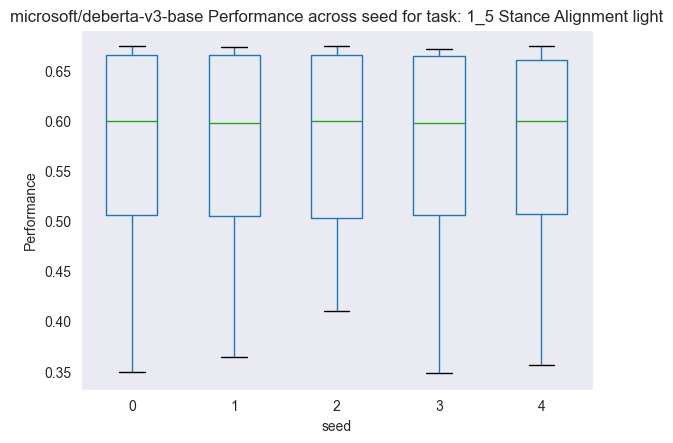

<Figure size 1000x600 with 0 Axes>

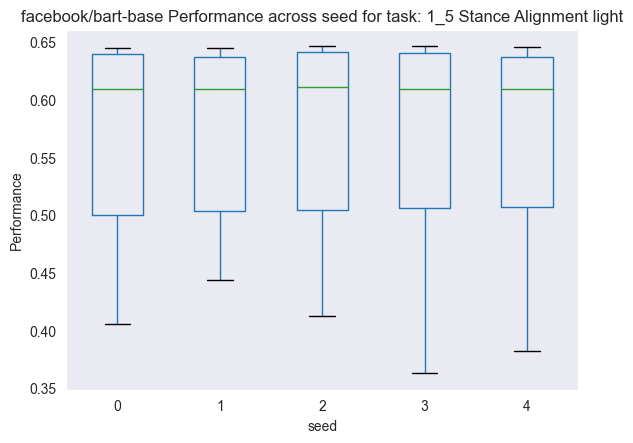

<Figure size 1000x600 with 0 Axes>

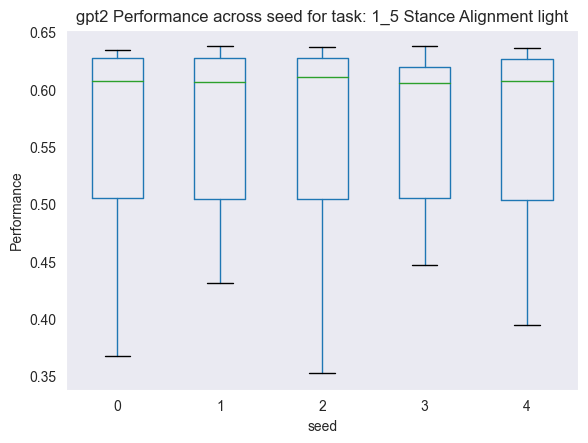

<Figure size 1000x600 with 0 Axes>

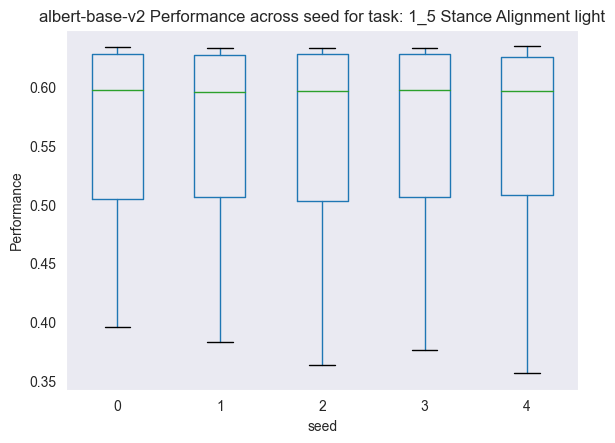

<Figure size 1000x600 with 0 Axes>

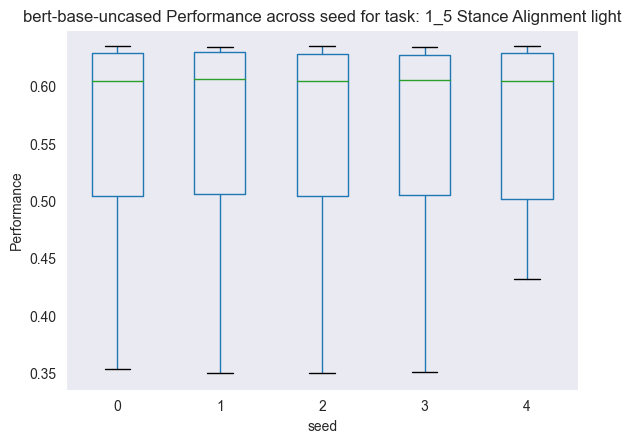


Task: 1 Stance Alignment


<Figure size 1000x600 with 0 Axes>

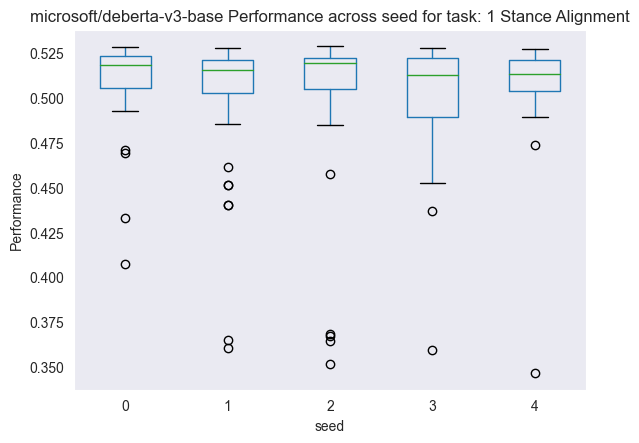

<Figure size 1000x600 with 0 Axes>

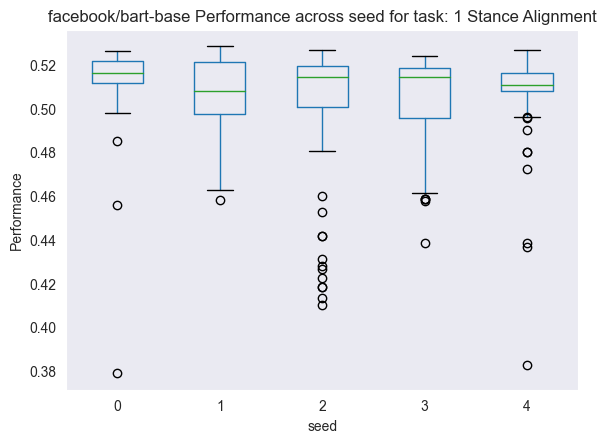

<Figure size 1000x600 with 0 Axes>

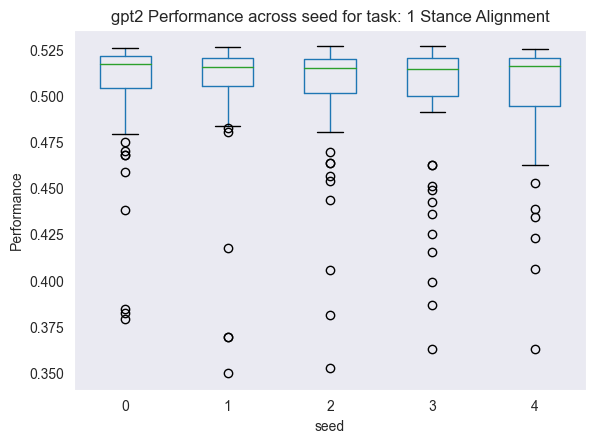

<Figure size 1000x600 with 0 Axes>

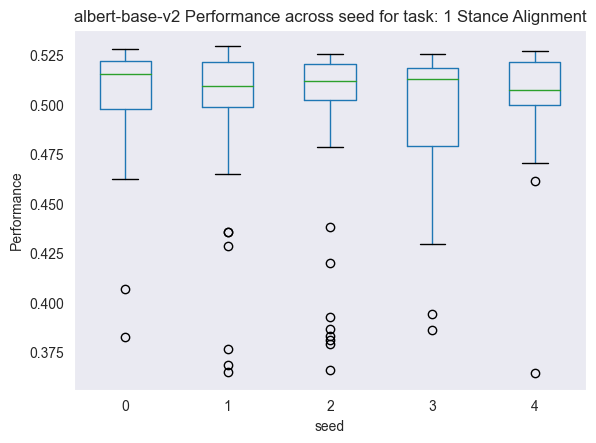

<Figure size 1000x600 with 0 Axes>

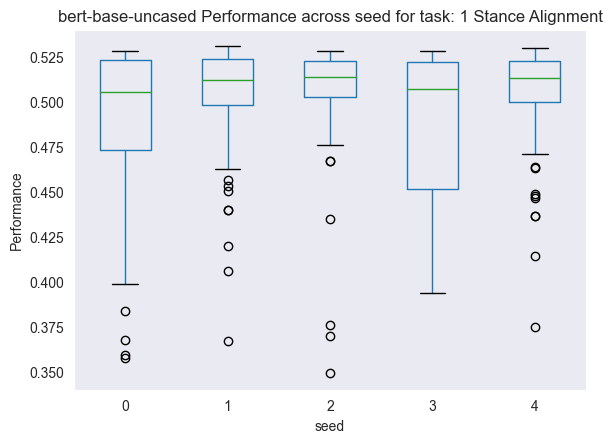


Task: 2 Sequential Coherence


<Figure size 1000x600 with 0 Axes>

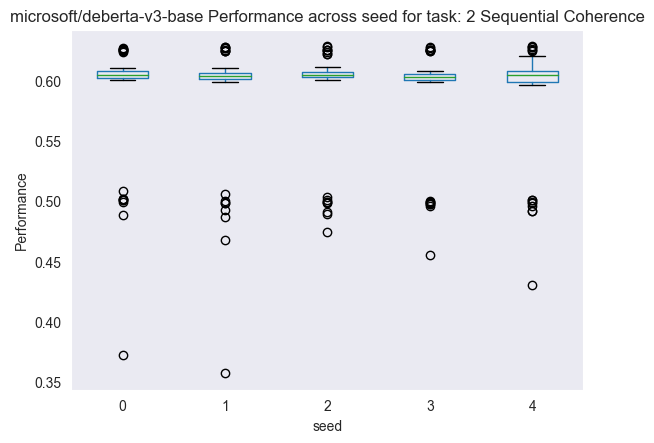

<Figure size 1000x600 with 0 Axes>

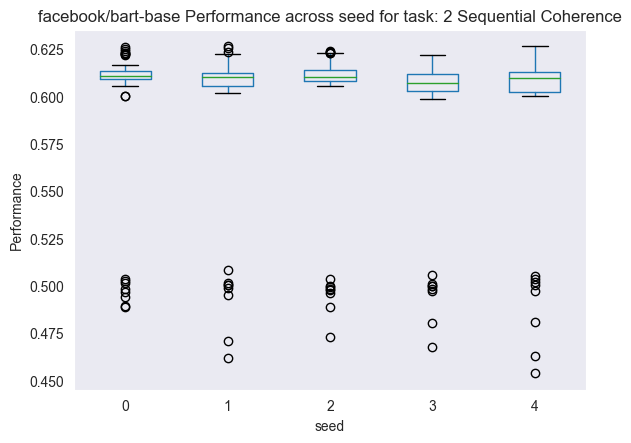

<Figure size 1000x600 with 0 Axes>

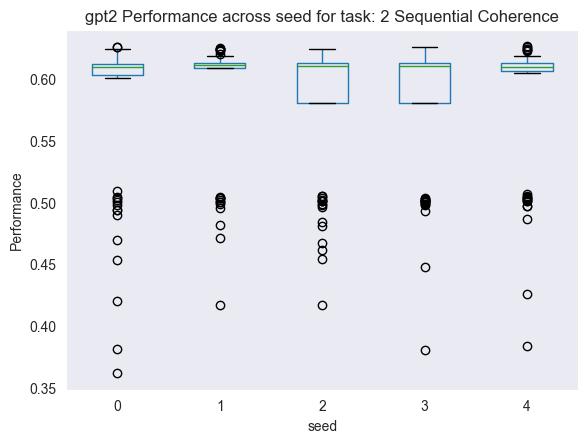

<Figure size 1000x600 with 0 Axes>

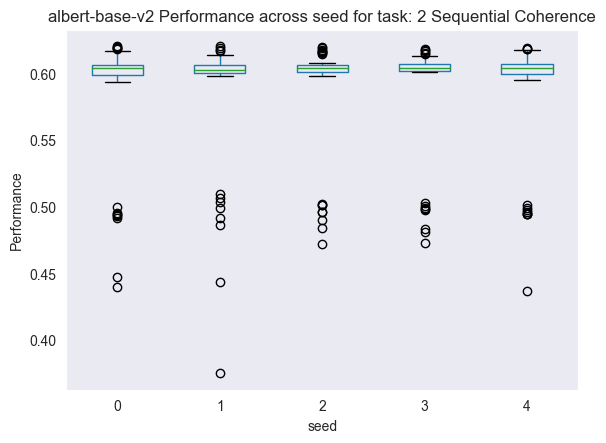

<Figure size 1000x600 with 0 Axes>

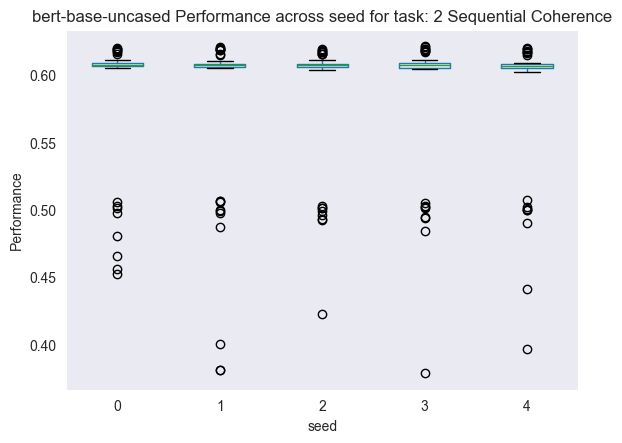


Task: 3 Interactive Dynamics


<Figure size 1000x600 with 0 Axes>

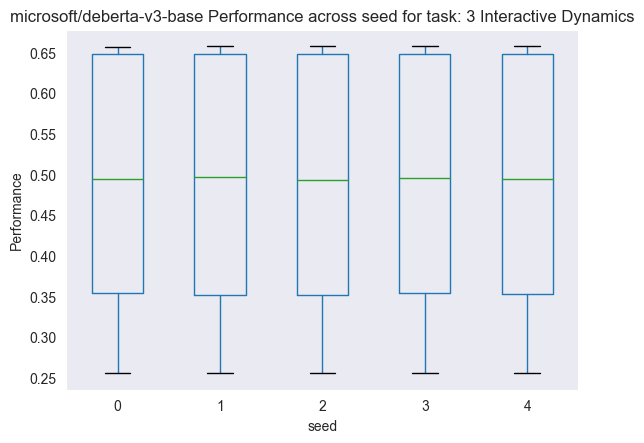

<Figure size 1000x600 with 0 Axes>

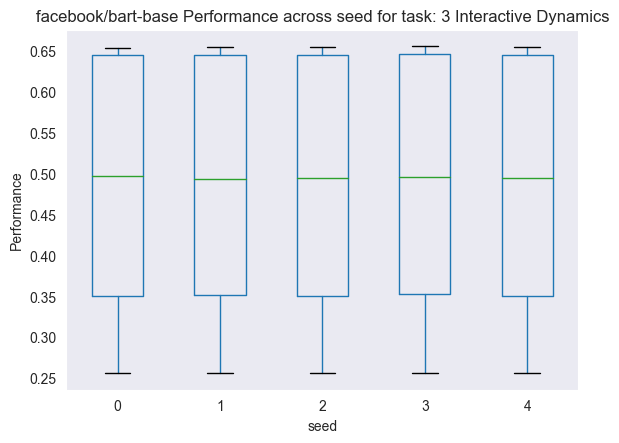

<Figure size 1000x600 with 0 Axes>

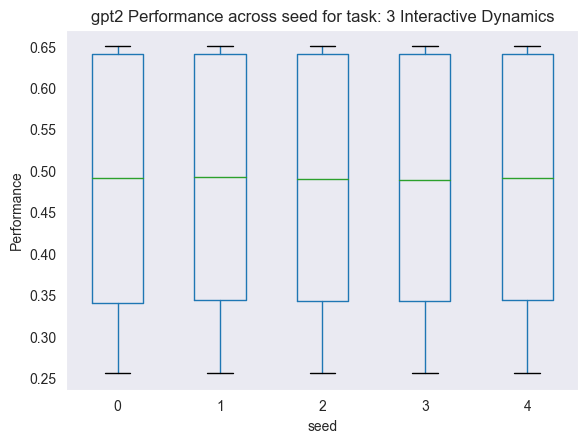

<Figure size 1000x600 with 0 Axes>

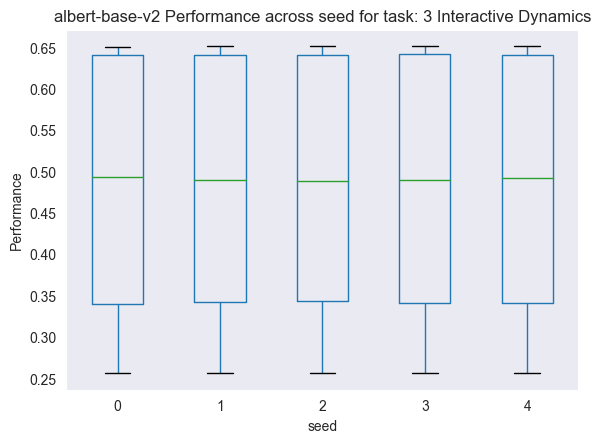

<Figure size 1000x600 with 0 Axes>

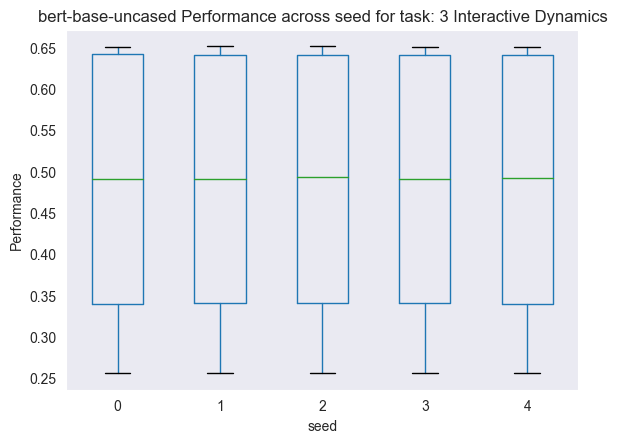


Task: 4 Claim Depth Hierarchy


<Figure size 1000x600 with 0 Axes>

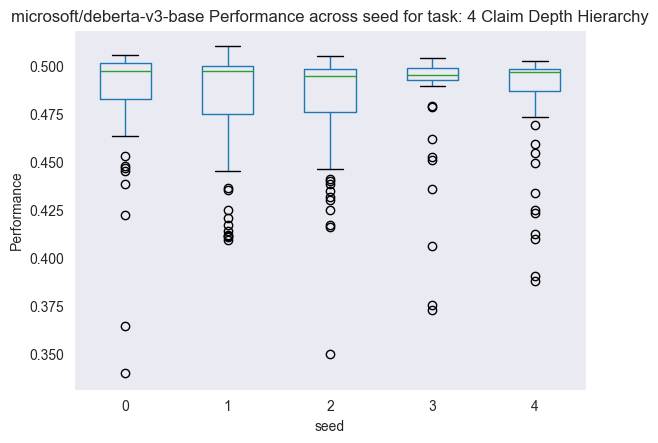

<Figure size 1000x600 with 0 Axes>

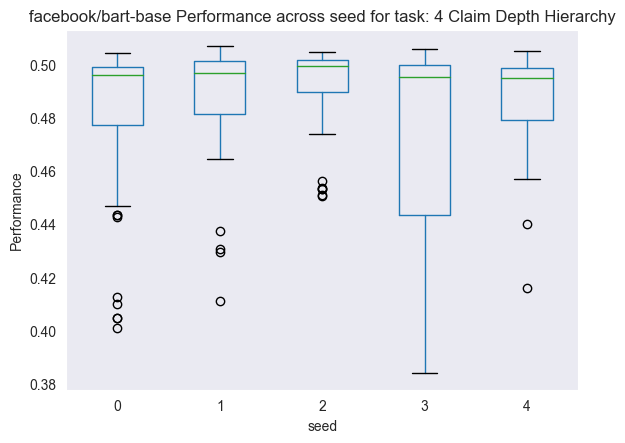

<Figure size 1000x600 with 0 Axes>

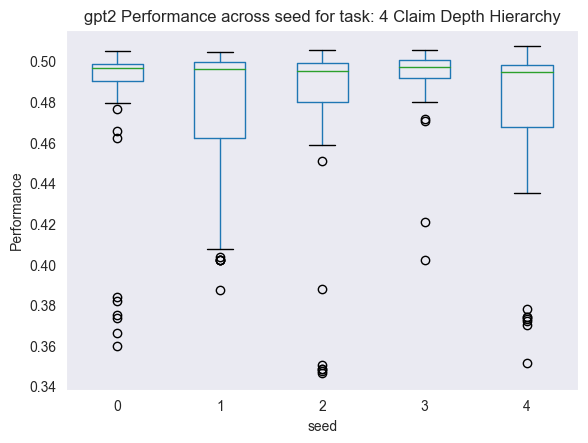

<Figure size 1000x600 with 0 Axes>

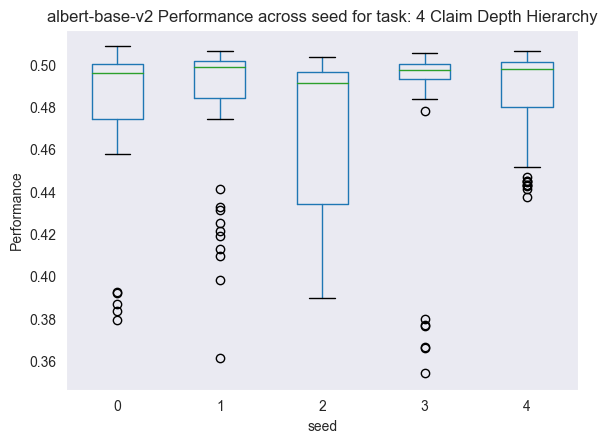

<Figure size 1000x600 with 0 Axes>

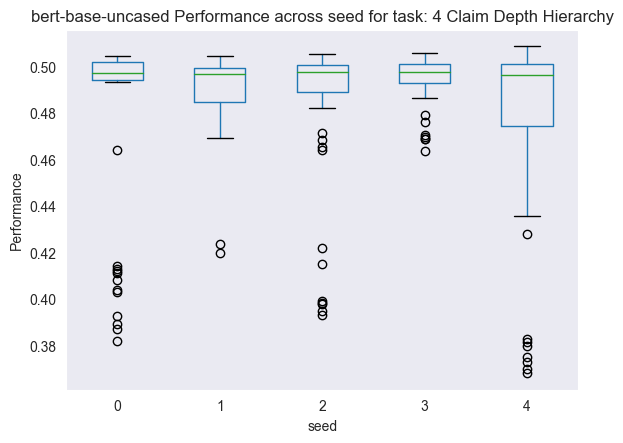


Task: 4_5 Claim Depth Hierarchy light


<Figure size 1000x600 with 0 Axes>

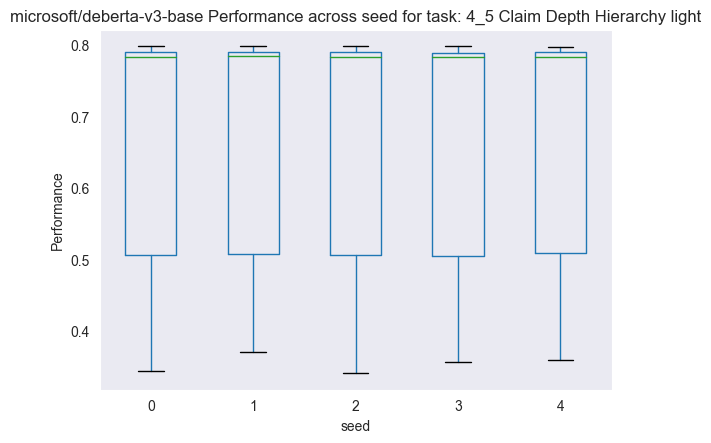

<Figure size 1000x600 with 0 Axes>

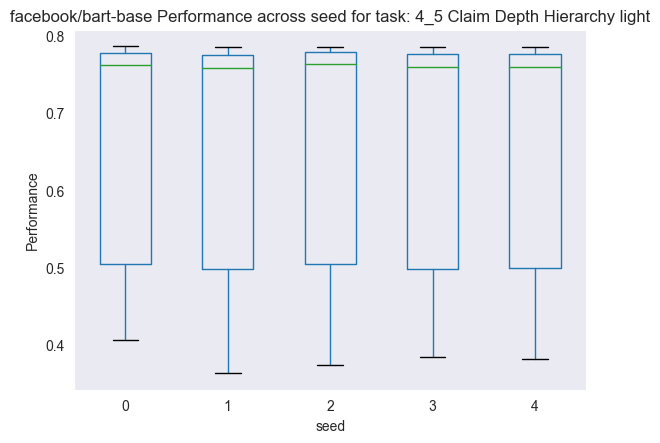

<Figure size 1000x600 with 0 Axes>

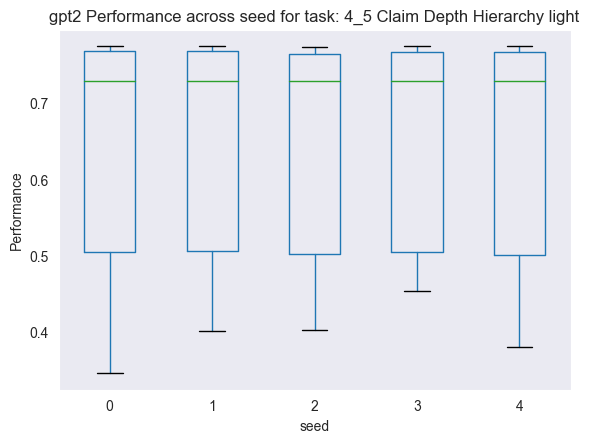

<Figure size 1000x600 with 0 Axes>

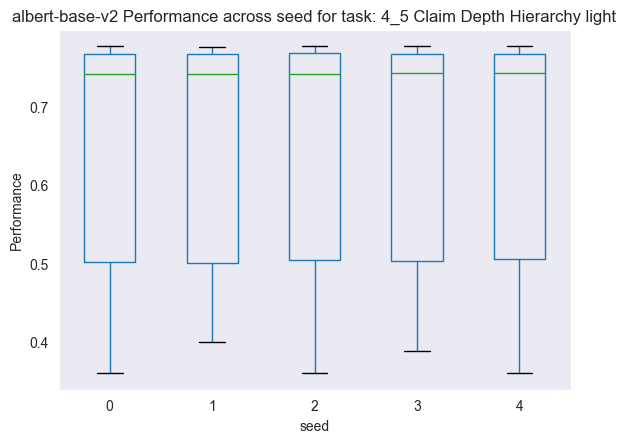

<Figure size 1000x600 with 0 Axes>

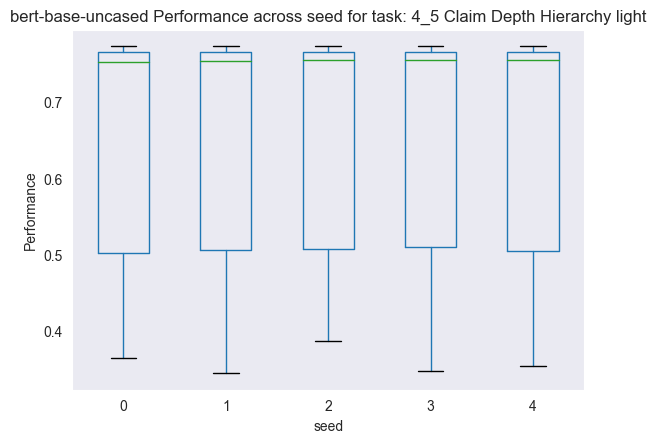


Task: 5 Discourse Contour Recognition


<Figure size 1000x600 with 0 Axes>

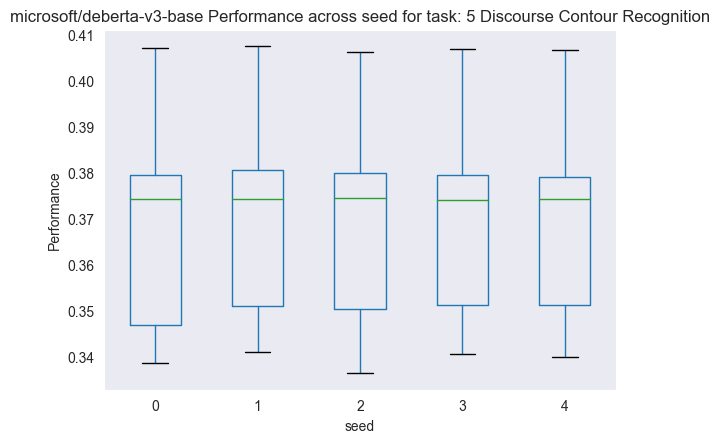

<Figure size 1000x600 with 0 Axes>

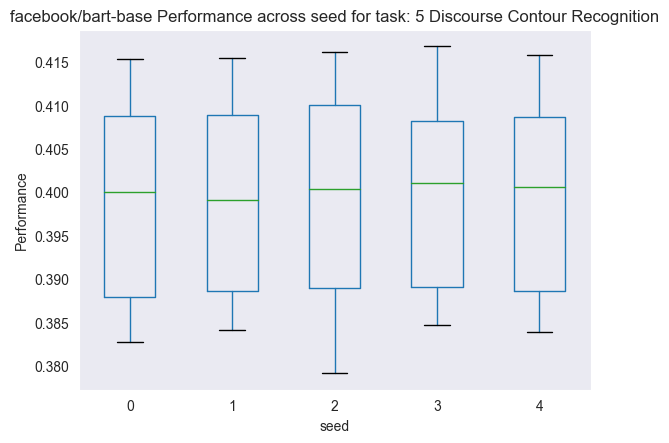

<Figure size 1000x600 with 0 Axes>

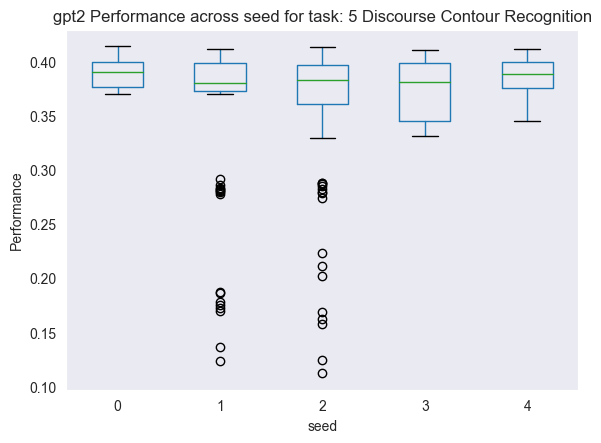

<Figure size 1000x600 with 0 Axes>

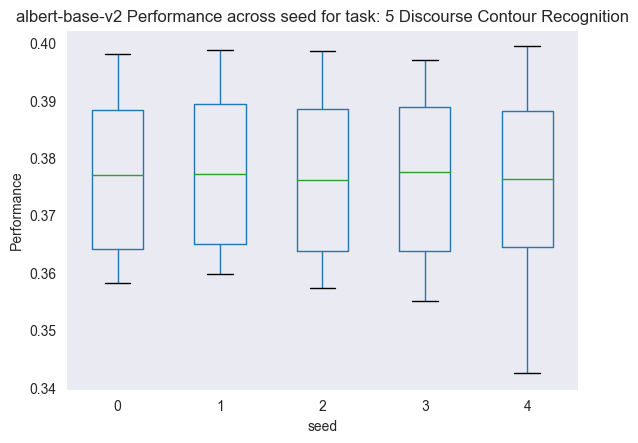

<Figure size 1000x600 with 0 Axes>

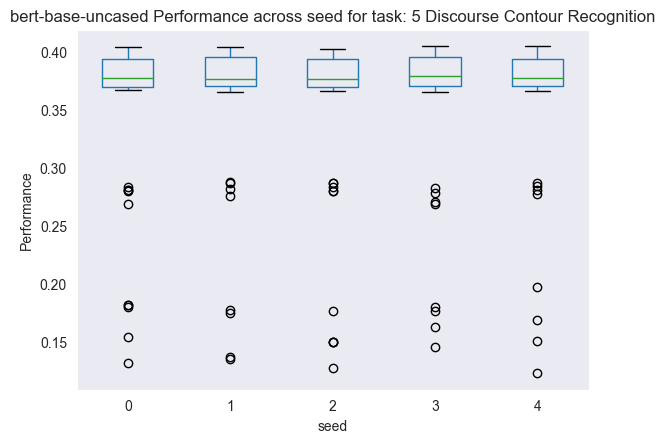


ANOVA Results for Fold Variability (Fixing Seed):

Task: 1_5 Stance Alignment light


<Figure size 1000x600 with 0 Axes>

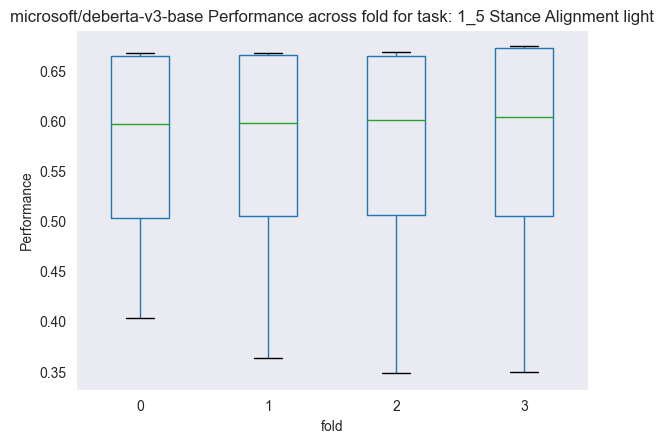

<Figure size 1000x600 with 0 Axes>

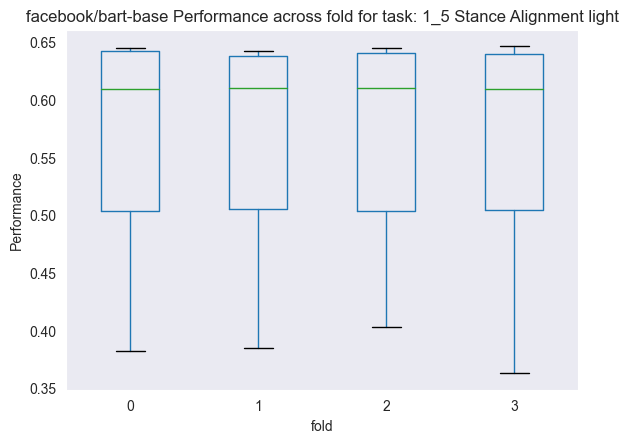

<Figure size 1000x600 with 0 Axes>

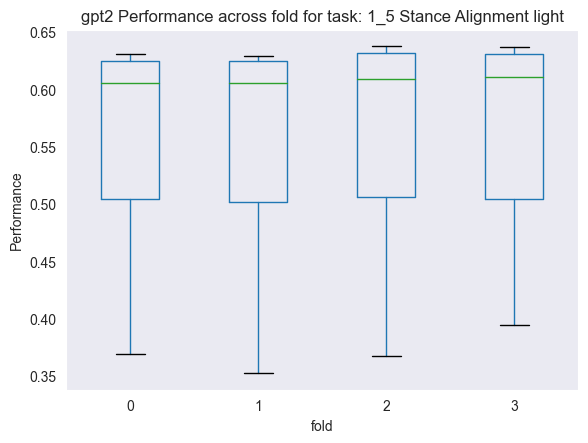

<Figure size 1000x600 with 0 Axes>

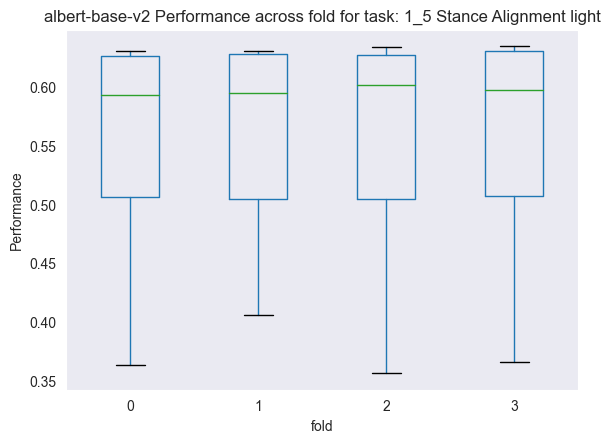

<Figure size 1000x600 with 0 Axes>

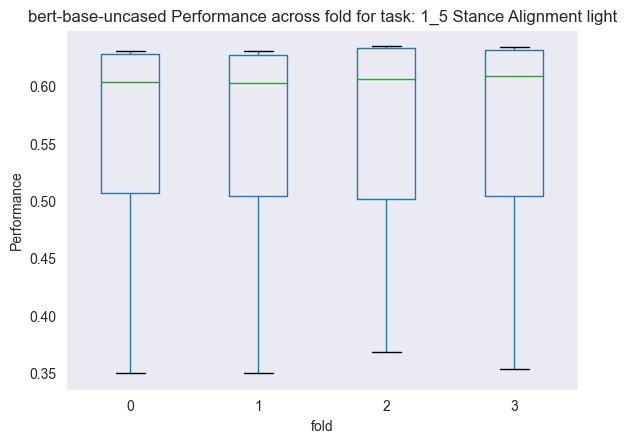


Task: 1 Stance Alignment


<Figure size 1000x600 with 0 Axes>

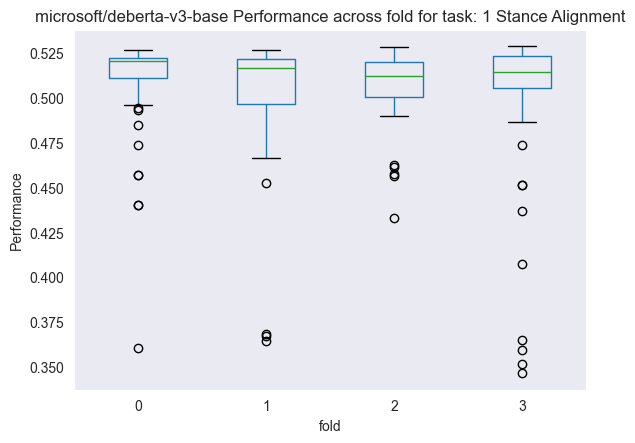

<Figure size 1000x600 with 0 Axes>

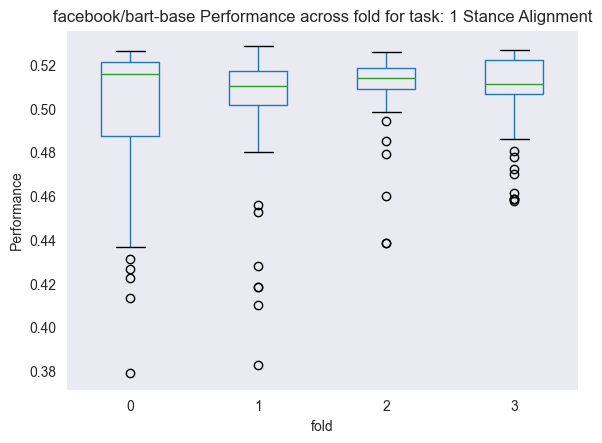

<Figure size 1000x600 with 0 Axes>

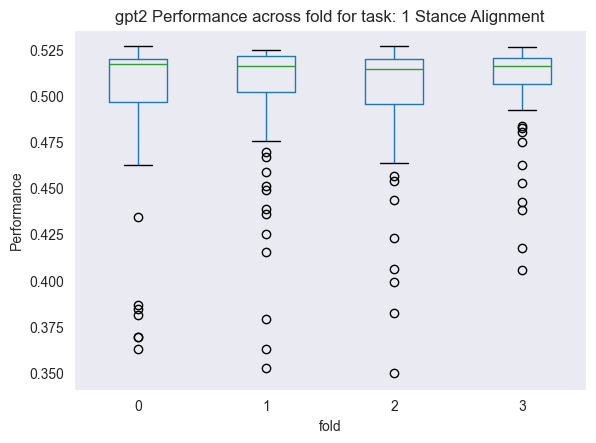

<Figure size 1000x600 with 0 Axes>

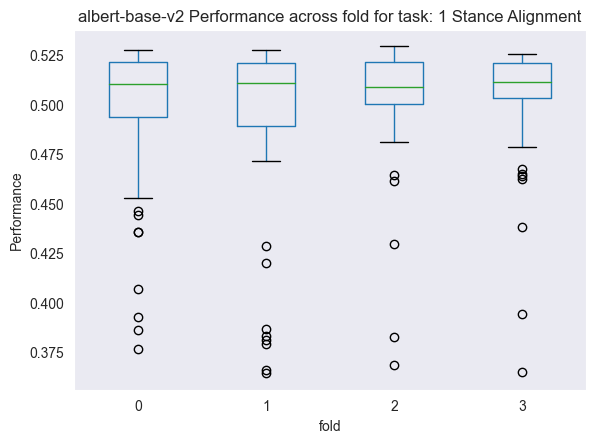

<Figure size 1000x600 with 0 Axes>

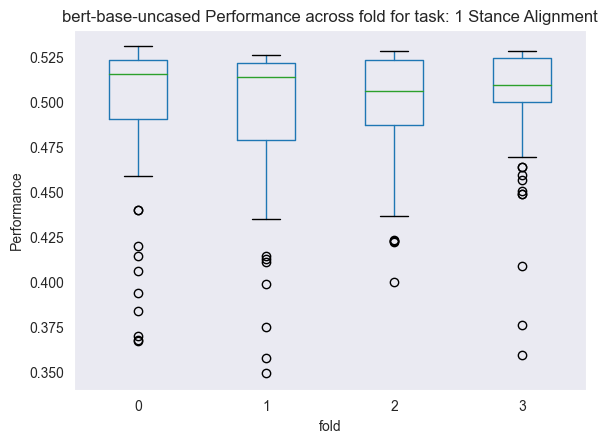


Task: 2 Sequential Coherence


<Figure size 1000x600 with 0 Axes>

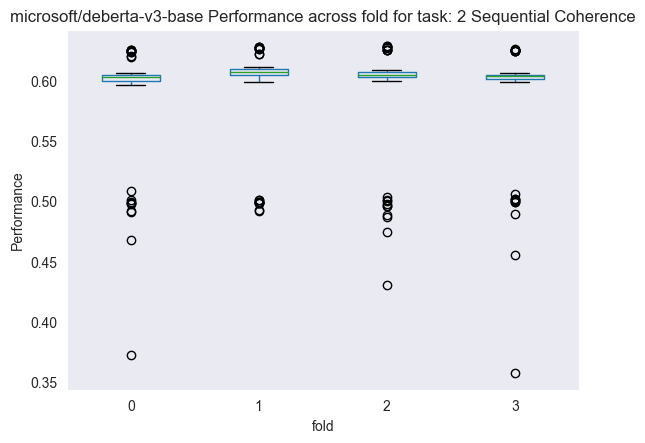

<Figure size 1000x600 with 0 Axes>

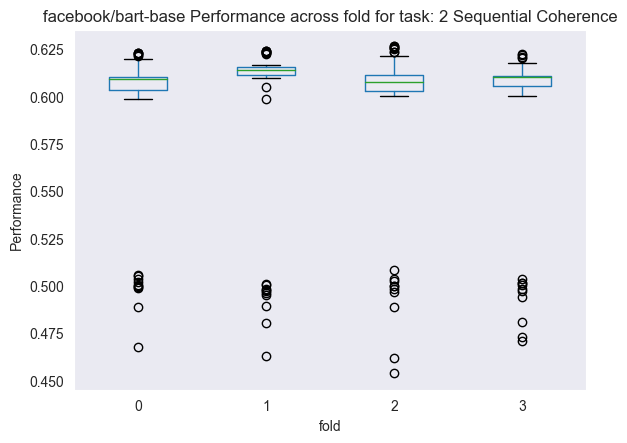

<Figure size 1000x600 with 0 Axes>

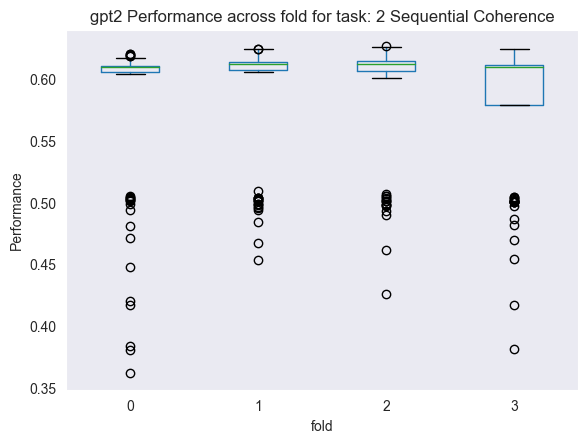

<Figure size 1000x600 with 0 Axes>

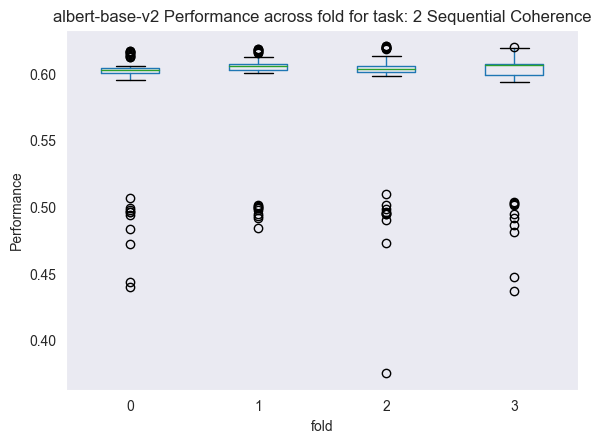

<Figure size 1000x600 with 0 Axes>

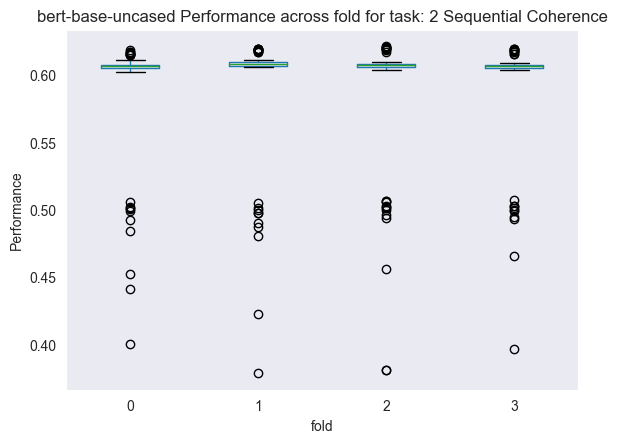


Task: 3 Interactive Dynamics


<Figure size 1000x600 with 0 Axes>

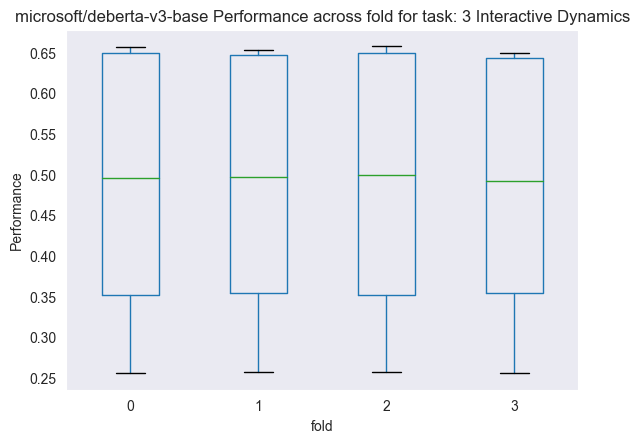

<Figure size 1000x600 with 0 Axes>

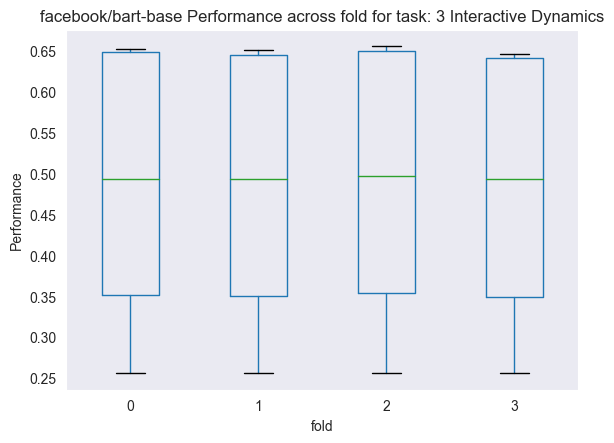

<Figure size 1000x600 with 0 Axes>

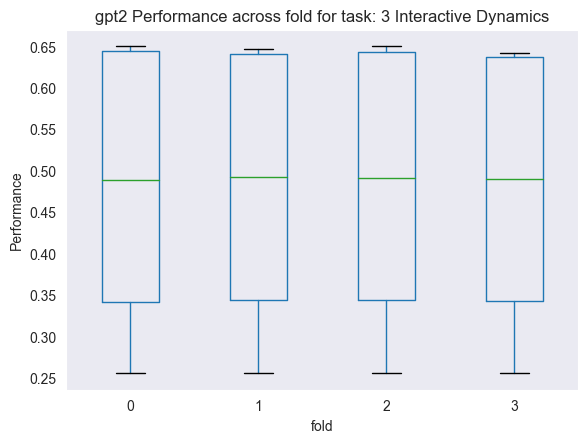

<Figure size 1000x600 with 0 Axes>

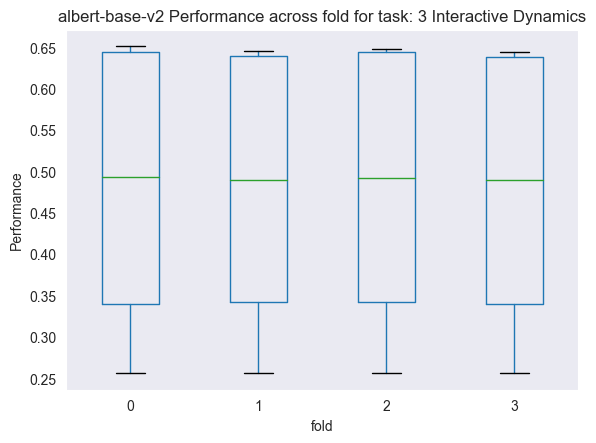

<Figure size 1000x600 with 0 Axes>

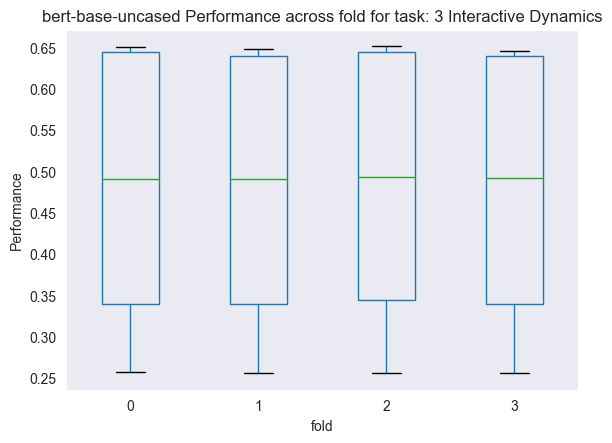


Task: 4 Claim Depth Hierarchy


<Figure size 1000x600 with 0 Axes>

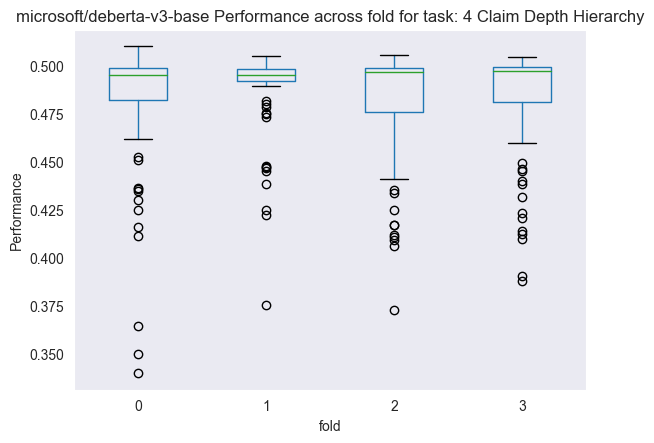

<Figure size 1000x600 with 0 Axes>

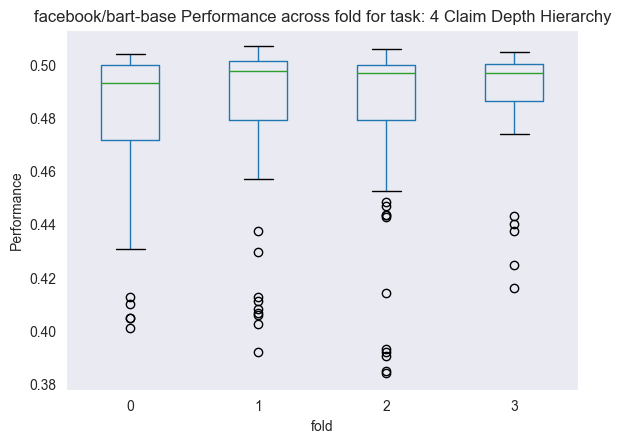

<Figure size 1000x600 with 0 Axes>

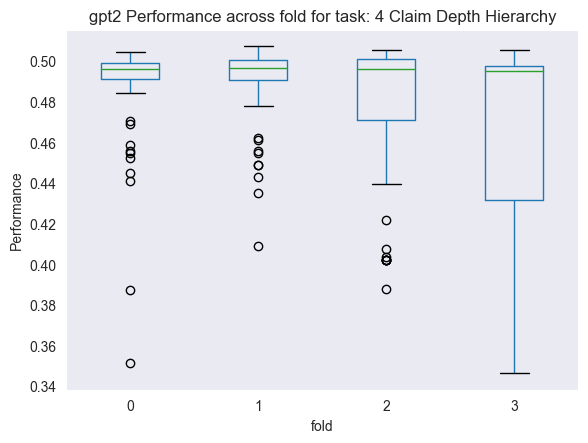

<Figure size 1000x600 with 0 Axes>

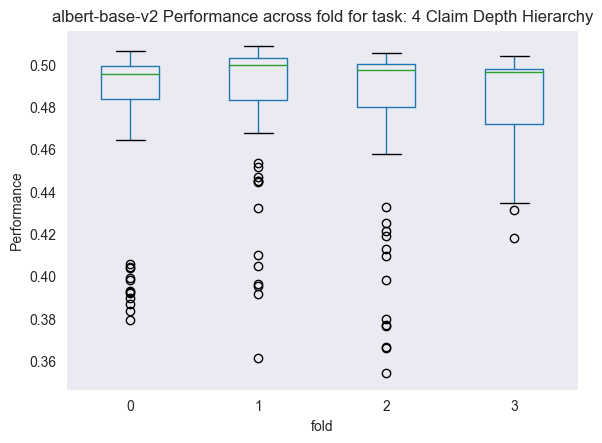

<Figure size 1000x600 with 0 Axes>

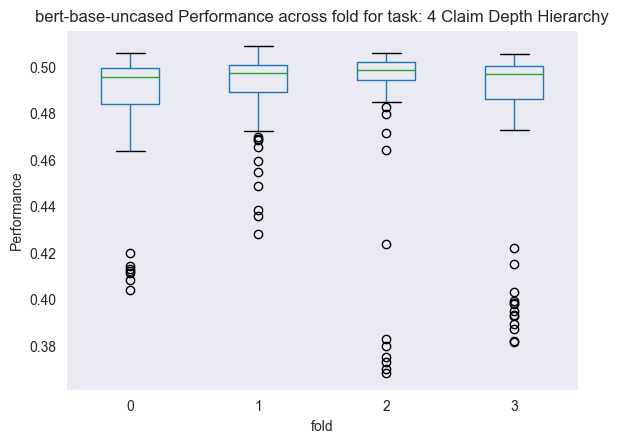


Task: 4_5 Claim Depth Hierarchy light


<Figure size 1000x600 with 0 Axes>

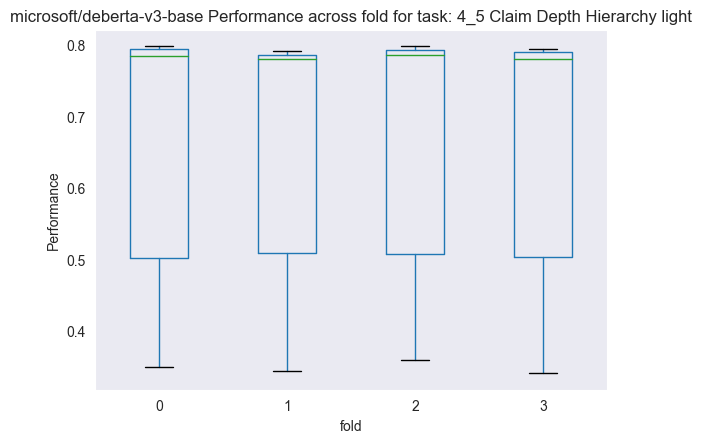

<Figure size 1000x600 with 0 Axes>

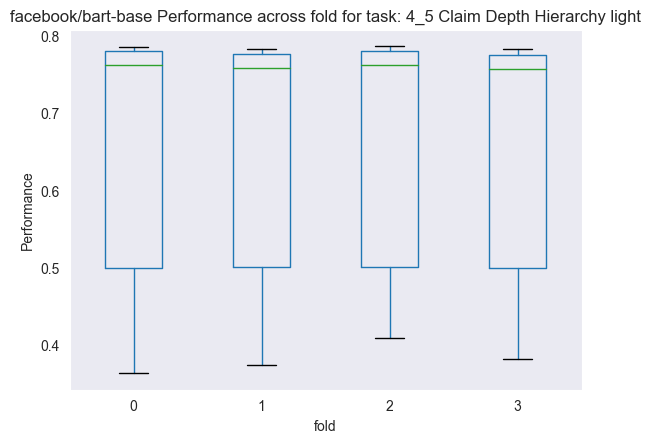

<Figure size 1000x600 with 0 Axes>

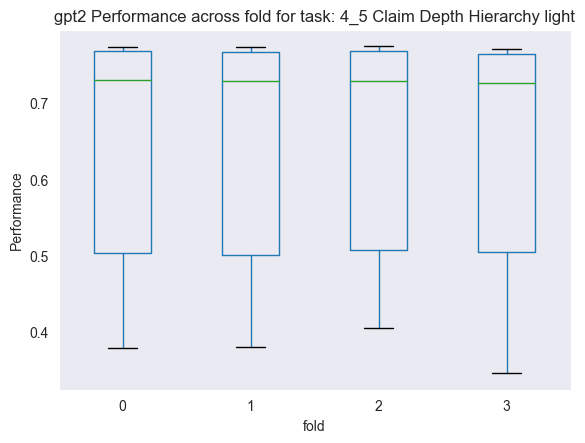

<Figure size 1000x600 with 0 Axes>

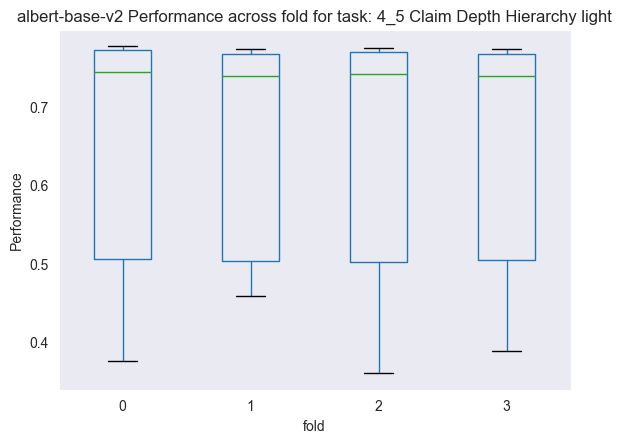

<Figure size 1000x600 with 0 Axes>

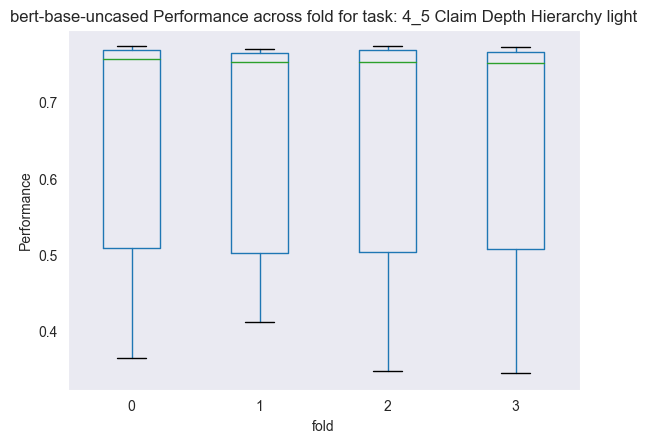


Task: 5 Discourse Contour Recognition


<Figure size 1000x600 with 0 Axes>

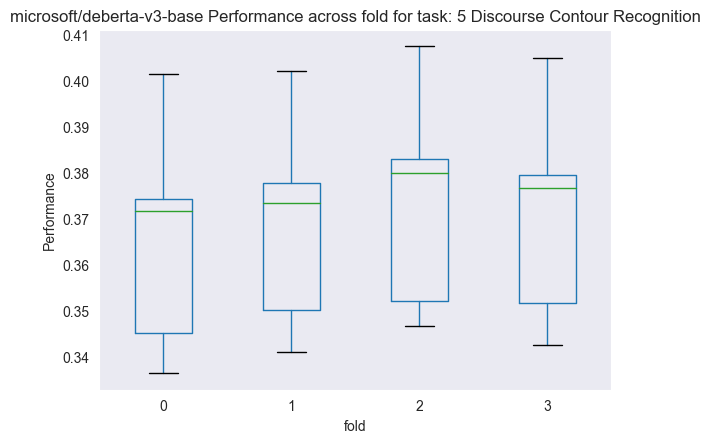

<Figure size 1000x600 with 0 Axes>

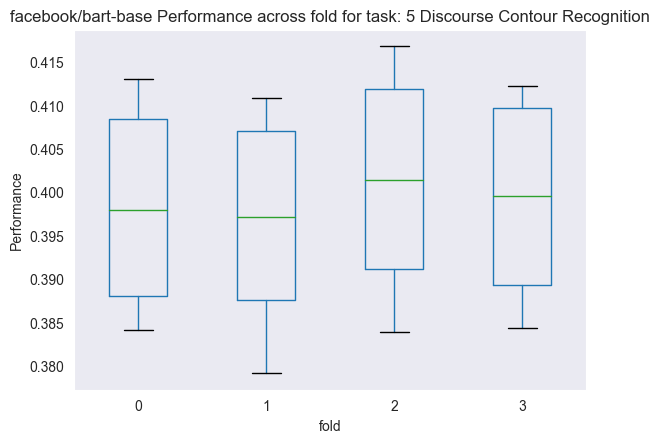

<Figure size 1000x600 with 0 Axes>

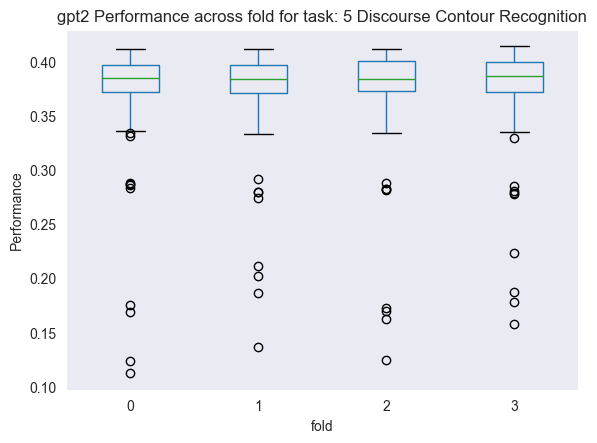

<Figure size 1000x600 with 0 Axes>

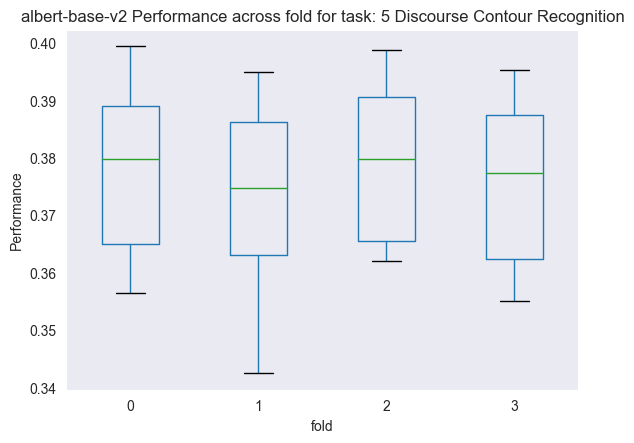

<Figure size 1000x600 with 0 Axes>

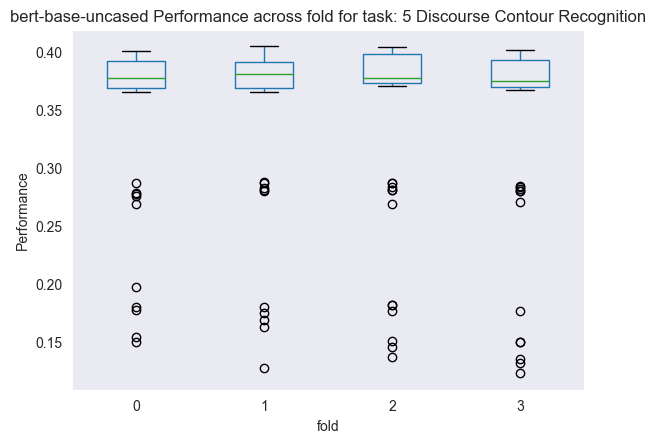

({'1_5 Stance Alignment light': {'microsoft/deberta-v3-base': 0.9927990686576976,
   'facebook/bart-base': 0.8956915157259344,
   'gpt2': 0.8978358048038838,
   'albert-base-v2': 0.9711106774814527,
   'bert-base-uncased': 0.664576053778853},
  '1 Stance Alignment': {'microsoft/deberta-v3-base': 0.48160546921530634,
   'facebook/bart-base': 0.029047525320623883,
   'gpt2': 0.9329678360057599,
   'albert-base-v2': 0.34659011838773157,
   'bert-base-uncased': 0.04570341673874489},
  '2 Sequential Coherence': {'microsoft/deberta-v3-base': 0.9973059302070801,
   'facebook/bart-base': 0.990357722573308,
   'gpt2': 0.906204765794698,
   'albert-base-v2': 0.9968795521267313,
   'bert-base-uncased': 0.9409117593743022},
  '3 Interactive Dynamics': {'microsoft/deberta-v3-base': 0.9999998575110515,
   'facebook/bart-base': 0.9999993936947864,
   'gpt2': 0.9999996626124353,
   'albert-base-v2': 0.9999995270984616,
   'bert-base-uncased': 0.9999999606837422},
  '4 Claim Depth Hierarchy': {'microso

In [50]:

data = context_df.copy()


def perform_anova_and_plot(data, fixed_factor, variable_factor, task):
    results = {}
    for model in MODELS:
        model_data = data[(data['model'] == model) & (data['project'] == task)]

        # Check if model_data is not empty to proceed with ANOVA
        if not model_data.empty:
            # Create a formula for ANOVA
            formula = f'value ~ C({fixed_factor}) + C({variable_factor})'
            model_anova = ols(formula, data=model_data).fit()
            anova_results = sm.stats.anova_lm(model_anova, typ=2)
            results[model] = anova_results['PR(>F)'][f'C({variable_factor})']

            # Plotting
            plt.figure(figsize=(10, 6))
            model_data.boxplot('value', by=variable_factor, grid=False)
            plt.title(f'{model} Performance across {variable_factor} for task: {task}')
            plt.suptitle('')
            plt.xlabel(variable_factor)
            plt.ylabel('Performance')
            plt.show()

    return results


# ANOVA for varying seed (fixing fold)
anova_results_seeds_corrected = {}
print("ANOVA Results for Seed Variability (Fixing Fold):")
for task in CONTEXT_TASKS:
    print(f"\nTask: {task}")
    seed_results = perform_anova_and_plot(data, 'fold', 'seed', task)
    anova_results_seeds_corrected[task] = seed_results

# ANOVA for varying fold (fixing seed)
anova_results_folds_corrected = {}
print("\nANOVA Results for Fold Variability (Fixing Seed):")
for task in CONTEXT_TASKS:
    print(f"\nTask: {task}")
    fold_results = perform_anova_and_plot(data, 'seed', 'fold', task)
    anova_results_folds_corrected[task] = fold_results

anova_results_seeds_corrected, anova_results_folds_corrected



# U Test Heatmaps for Control Tasks

In [53]:
TASKS = list(context_df['project'].unique())


# Function to count significant differences in U-tests for each model, task, seed, and fold combination
def count_u_test_significant_diff_original(df, control_task, alternative='greater'):
    results = {model: {task: {'total': 0, 'significant_diff_count': 0} for task in TASKS} for model in MODELS}
    for model in MODELS:
        for task in TASKS:
            for seed in SEEDS:
                for fold in FOLDS:
                    # Filter values for the task (NONE) and the specific control task
                    task_values = df[(df['model'] == model) & (df['project'] == task) &
                                     (df['seed'] == seed) & (df['fold'] == fold) &
                                     (df['control_task'] == 'NONE')]['value']
                    control_values = df[(df['model'] == model) & (df['project'] == task) &
                                        (df['seed'] == seed) & (df['fold'] == fold) &
                                        (df['control_task'] == control_task)]['value']

                    if not task_values.empty and not control_values.empty:
                        results[model][task]['total'] += 1
                        u_stat, p_value = mannwhitneyu(task_values, control_values, alternative=alternative)
                        if p_value < 0.05:
                            results[model][task]['significant_diff_count'] += 1
    return results


# Recalculate significant differences for RANDOMIZATION and PERMUTATION control tasks
randomization_original_results = count_u_test_significant_diff_original(context_df, 'RANDOMIZATION')
permutation_original_results = count_u_test_significant_diff_original(context_df, 'PERMUTATION', alternative='less')



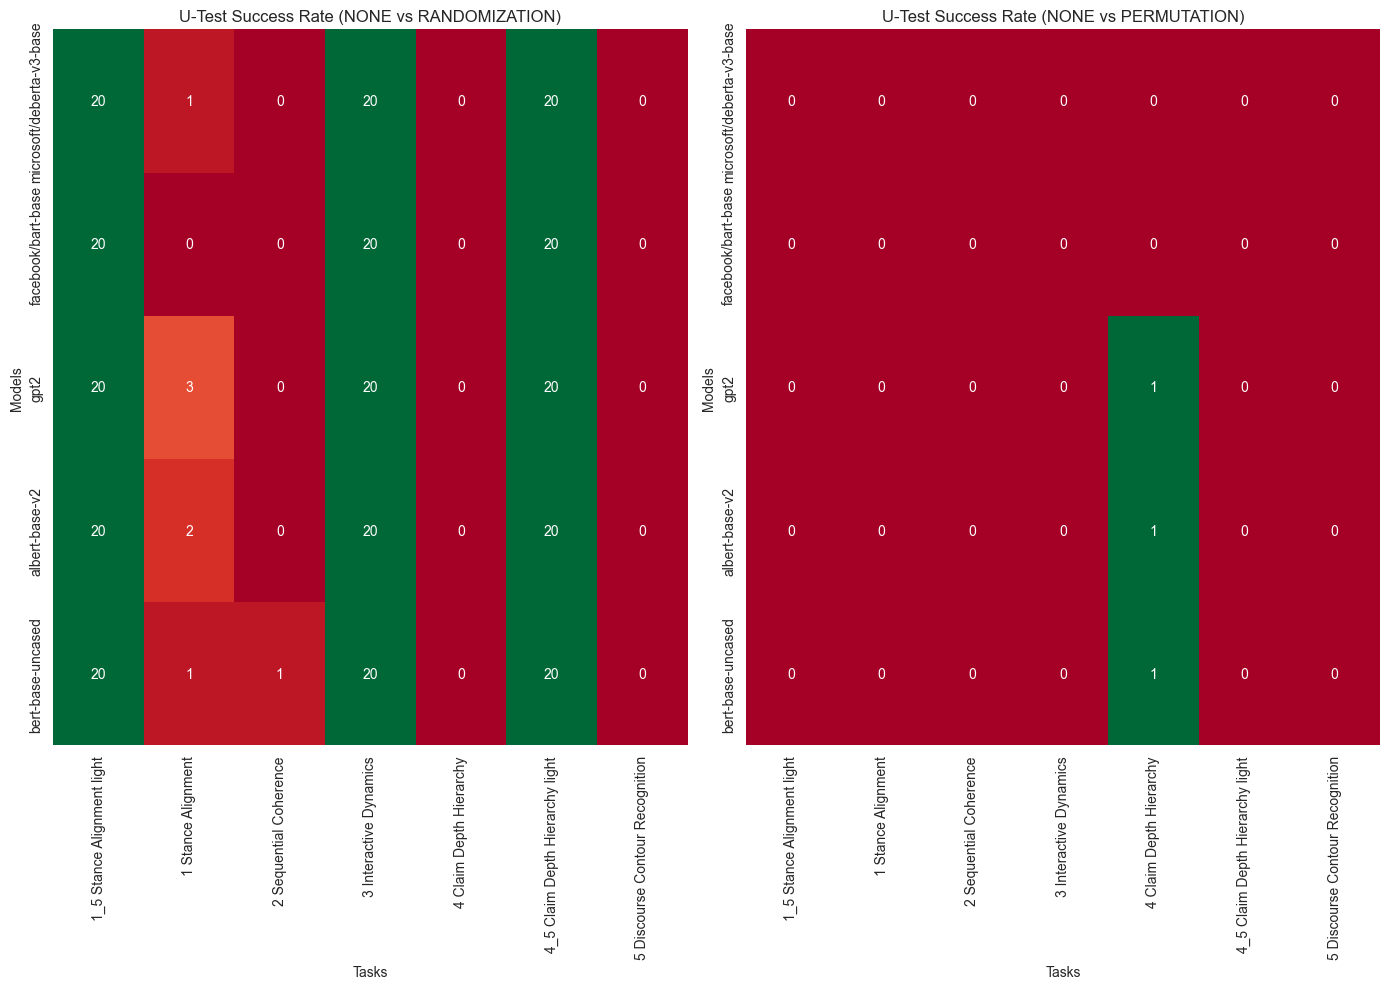

In [54]:
# Adjusted function to correctly transform the results dictionary into a DataFrame
def results_to_df_adjusted(results):
    data = []
    for model in MODELS:
        model_results = []
        for task in TASKS:
            model_results.append(results[model][task]['significant_diff_count'])
        data.append(model_results)

    heatmap_df = pd.DataFrame(data, index=MODELS, columns=TASKS)
    return heatmap_df


# Transform the original results into DataFrames
randomization_heatmap_df_adjusted = results_to_df_adjusted(randomization_original_results)
permutation_heatmap_df_adjusted = results_to_df_adjusted(permutation_original_results)

# Plotting the adjusted heatmaps
plt.figure(figsize=(14, 10))

# Randomization heatmap (adjusted)
plt.subplot(1, 2, 1)
sns.heatmap(randomization_heatmap_df_adjusted, annot=True, cmap="RdYlGn", cbar=False)
plt.title("U-Test Success Rate (NONE vs RANDOMIZATION)")
plt.xlabel("Tasks")
plt.ylabel("Models")

# Permutation heatmap (adjusted)
plt.subplot(1, 2, 2)
sns.heatmap(permutation_heatmap_df_adjusted, annot=True, cmap="RdYlGn", cbar=False)
plt.title("U-Test Success Rate (NONE vs PERMUTATION)")
plt.xlabel("Tasks")
plt.ylabel("Models")

plt.tight_layout()
plt.show()


In [ ]:
observations_per_group = context_df.groupby(['model', 'project', 'seed', 'fold']).size()

min_observations = observations_per_group.min()
max_observations = observations_per_group.max()

min_observations, max_observations

In [ ]:
def assign_model_group(model_name):
    for group, models in MODEL_GROUPS.items():
        if model_name in models:
            return group
    return "Unknown"


context_df['model_group'] = context_df['model'].apply(assign_model_group)

In [ ]:
import scipy.stats as stats

# Apply the project name mapping to both dataframes
context_df['project_name'] = context_df['project'].map(project_name_mapping)
no_context_df['project_name'] = no_context_df['project'].map(project_name_mapping)

# Filter for 'NONE' control task and 'full test f1' metric in both dataframes
context_data = context_df[(context_df['control_task'] == 'NONE') & (context_df['metric'] == 'full test f1')]
no_context_data = no_context_df[(no_context_df['control_task'] == 'NONE') & (no_context_df['metric'] == 'full test f1')]

# Combine context and no-context data for analysis, with a condition label
context_data['Condition'] = 'Context'
no_context_data['Condition'] = 'No Context'
combined_data = pd.concat([context_data, no_context_data])

# Conduct the Shapiro-Wilk test for normality on the F1 scores
shapiro_results = combined_data.groupby(['project_name', 'model', 'Condition'])['value'].apply(
    lambda x: stats.shapiro(x.values)).reset_index()
shapiro_results[['Shapiro-Wilk', 'p-value']] = pd.DataFrame(shapiro_results['value'].tolist(),
                                                            index=shapiro_results.index)
shapiro_results.drop(columns=['value'], inplace=True)

# Visualize the distributions as boxplots
plt.figure(figsize=(14, 7))
sns.boxplot(x='project_name', y='value', hue='Condition', data=combined_data, palette=['red', 'yellow'])
plt.title('Distribution of F1 Scores for Context vs No Context')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.xlabel("Probing Task")
plt.ylabel("F1 Score")
plt.show()


In [ ]:
shapiro_results[shapiro_results["p-value"] > 0.05]
shapiro_results

In [ ]:


# Grouping data by control task, project, model group, and metric
grouped_data_project = context_df.groupby(['control_task', 'project', 'model_group', 'metric']).median(
    numeric_only=True).reset_index()
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

# Define the order of projects based on the new names given
project_order = [
    "1 Stance Alignment",
    "1_5 Stance Alignment light",
    "2 Sequential Coherence",
    "3 Interactive Dynamics",
    "4 Claim Depth Hierarchy",
    "4_5 Claim Depth Hierarchy light",
    "5 Discourse Contour Recognition"
]

# Plot for random baseline performance
sns.barplot(
    x='project',
    y='value',
    hue='model_group',
    data=grouped_data_project[grouped_data_project['control_task'] == 'RANDOMIZATION'],
    order=project_order,
    ax=axes[0]
)
axes[0].set_title('Random Performance (Control Task)')
axes[0].tick_params(axis='x', rotation=45)

# Plot for probe performance
sns.barplot(
    x='project',
    y='value',
    hue='model_group',
    data=grouped_data_project[grouped_data_project['control_task'] == 'NONE'],
    order=project_order,
    ax=axes[1]
)
axes[1].set_title('Probe Performance')
axes[1].tick_params(axis='x', rotation=45)

# Plot for permutation task performance
sns.barplot(
    x='project',
    y='value',
    hue='model_group',
    data=grouped_data_project[grouped_data_project['control_task'] == 'PERMUTATION'],
    order=project_order,
    ax=axes[2]
)
axes[2].set_title('Permutation Performance (Control Task)')
axes[2].tick_params(axis='x', rotation=45)

# Set the y-axis limit to be consistent across all subplots
for ax in axes:
    ax.set_ylim(0, 0.8)

plt.tight_layout()
plt.show()

In [ ]:

data = context_df.copy()


def perform_anova_and_plot_corrected(data, fixed_factor, variable_factor, task):
    results = {}
    for model in MODELS:
        model_data = data[(data['model'] == model) & (data['project'] == task)]

        # Check if model_data is not empty to proceed with ANOVA
        if not model_data.empty:
            # Create a formula for ANOVA
            formula = f'value ~ C({fixed_factor}) + C({variable_factor})'
            model_anova = ols(formula, data=model_data).fit()
            anova_results = sm.stats.anova_lm(model_anova, typ=2)
            results[model] = anova_results['PR(>F)'][f'C({variable_factor})']

            # Plotting
            plt.figure(figsize=(10, 6))
            model_data.boxplot('value', by=variable_factor, grid=False)
            plt.title(f'{model} Performance across {variable_factor} for task: {task}')
            plt.suptitle('')
            plt.xlabel(variable_factor)
            plt.ylabel('Performance')
            #plt.show()

    return results


# ANOVA for varying seed (fixing fold)
anova_results_seeds_corrected = {}
print("ANOVA Results for Seed Variability (Fixing Fold):")
for task in TASKS:
    print(f"\nTask: {task}")
    seed_results = perform_anova_and_plot_corrected(data, 'fold', 'seed', task)
    anova_results_seeds_corrected[task] = seed_results

# ANOVA for varying fold (fixing seed)
anova_results_folds_corrected = {}
print("\nANOVA Results for Fold Variability (Fixing Seed):")
for task in TASKS:
    print(f"\nTask: {task}")
    fold_results = perform_anova_and_plot_corrected(data, 'seed', 'fold', task)
    anova_results_folds_corrected[task] = fold_results

anova_results_seeds_corrected, anova_results_folds_corrected



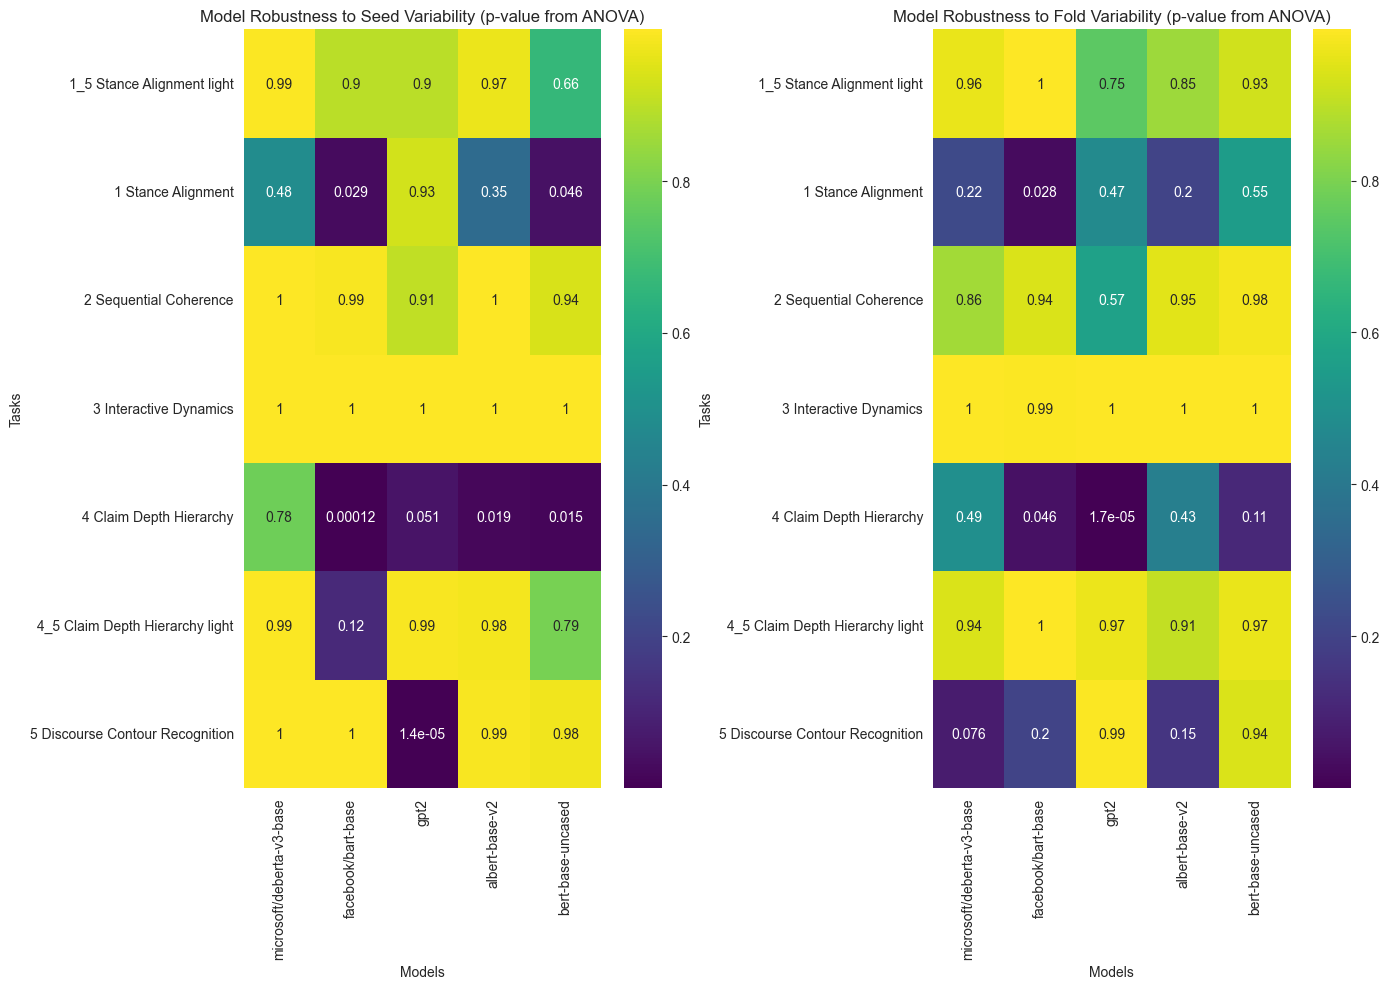

In [51]:
import numpy as np


# Function to create a heatmap DataFrame from ANOVA results
def create_heatmap_df_from_anova(anova_results):
    heatmap_data = []
    for task, task_results in anova_results.items():
        task_row = []
        for model in MODELS:
            # If the model has results for this task, use the p-value; otherwise, use NaN
            p_value = task_results.get(model, np.nan)
            task_row.append(p_value)
        heatmap_data.append(task_row)

    heatmap_df = pd.DataFrame(heatmap_data, index=TASKS, columns=MODELS)
    return heatmap_df


# Create heatmaps for seed and fold variability
seed_heatmap_df = create_heatmap_df_from_anova(anova_results_seeds_corrected)
fold_heatmap_df = create_heatmap_df_from_anova(anova_results_folds_corrected)

# Plotting the heatmaps
plt.figure(figsize=(14, 10))

# Heatmap for Seed Variability
plt.subplot(1, 2, 1)
sns.heatmap(seed_heatmap_df, annot=True, cmap="viridis", cbar=True)
plt.title("Model Robustness to Seed Variability (p-value from ANOVA)")
plt.xlabel("Models")
plt.ylabel("Tasks")

# Heatmap for Fold Variability
plt.subplot(1, 2, 2)
sns.heatmap(fold_heatmap_df, annot=True, cmap="viridis", cbar=True)
plt.title("Model Robustness to Fold Variability (p-value from ANOVA)")
plt.xlabel("Models")
plt.ylabel("Tasks")

plt.tight_layout()
plt.show()


In [ ]:
# Filter the data for 'full test f1' metric
f1_data = context_df[context_df['metric'] == 'full test f1']

# Calculate median F1 score for each model, project, and control task
median_scores = f1_data.groupby(['model', 'project', 'control_task'])['value'].median().reset_index()

# Pivot the data for easier comparison between NONE and RANDOMIZATION control tasks
pivot_data = median_scores.pivot_table(index=['model', 'project'], columns='control_task', values='value').reset_index()

# Calculate the selectivity (difference between NONE and RANDOMIZATION)
pivot_data['selectivity'] = pivot_data['NONE'] - pivot_data['RANDOMIZATION']

# Display the pivot data with selectivity for verification
pivot_data

In [ ]:
import pandas as pd

# Load the data
wandb_df = pd.read_csv('path_to_wandb_data.csv')

# Filter for 'full test f1' metric and relevant columns
relevant_data = wandb_df[wandb_df['metric'] == 'full test f1'][['project', 'model', 'control_task', 'value']]

# Group by project, model, and control task, then calculate mean F1 score
grouped_data = relevant_data.groupby(['project', 'model', 'control_task']).mean().reset_index()


# Function to calculate and normalize the difference between control tasks
def calculate_normalized_selectivity(df, control_task):
    none_data = df[df['control_task'] == 'NONE']
    control_data = df[df['control_task'] == control_task]
    merged_df = pd.merge(none_data, control_data, on=['project', 'model'], suffixes=('_none', '_control'))
    merged_df['selectivity'] = merged_df['value_none'] - merged_df['value_control']
    merged_df['normalized_selectivity'] = merged_df['selectivity'] / (
                merged_df['value_none'] + merged_df['value_control'])
    return merged_df


# Calculating normalized differences for randomization and permutation control tasks
normalized_select_random = calculate_normalized_selectivity(grouped_data, 'RANDOMIZATION')
normalized_select_perm = calculate_normalized_selectivity(grouped_data, 'PERMUTATION')

# Sorting the data for visualization
normalized_diff_random_sorted = normalized_select_random.sort_values(by='normalized_selectivity', ascending=False)
normalized_diff_perm_sorted = normalized_select_perm.sort_values(by='normalized_diff', ascending=False)

# The sorted dataframes are now ready for visualization


In [28]:
pivot_data

control_task,model,project,NONE,PERMUTATION,RANDOMIZATION,selectivity
0,albert-base-v2,1 Stance Alignment,0.503131,0.504879,0.486931,0.016200
1,albert-base-v2,1_5 Stance Alignment light,0.628084,0.594903,0.485260,0.142824
2,albert-base-v2,2 Sequential Coherence,0.616286,0.603290,0.485122,0.131164
3,albert-base-v2,3 Interactive Dynamics,0.354439,0.341555,0.256809,0.097630
4,albert-base-v2,4 Claim Depth Hierarchy,0.484198,0.476132,0.493685,-0.009487
5,albert-base-v2,4_5 Claim Depth Hierarchy light,0.768255,0.739047,0.484141,0.284114
6,albert-base-v2,5 Discourse Contour Recognition,0.370303,0.363469,0.370303,0.000000
7,bert-base-uncased,1 Stance Alignment,0.498961,0.498374,0.465699,0.033262
8,bert-base-uncased,1_5 Stance Alignment light,0.629714,0.603981,0.478904,0.150810
9,bert-base-uncased,2 Sequential Coherence,0.618077,0.606799,0.480417,0.137660


In [35]:
pivot_data[pivot_data["project"] == "5 Discourse Contour Recognition"]

control_task,model,project,NONE,PERMUTATION,RANDOMIZATION,selectivity
6,albert-base-v2,5 Discourse Contour Recognition,0.370303,0.363469,0.370303,0.000000
13,bert-base-uncased,5 Discourse Contour Recognition,0.376629,0.369770,0.189576,0.187052
20,facebook/bart-base,5 Discourse Contour Recognition,0.388624,0.388751,0.388625,-0.000001
27,gpt2,5 Discourse Contour Recognition,0.383902,0.374369,0.345420,0.038483
34,microsoft/deberta-v3-base,5 Discourse Contour Recognition,0.377465,0.346870,0.377465,0.000000


In [37]:
pivot_data.columns

Index(['model', 'project', 'NONE', 'PERMUTATION', 'RANDOMIZATION',
       'selectivity'],
      dtype='object', name='control_task')

In [36]:
pivot_data.groupby(["model", "project"]).median()

control_task                                                   NONE  \
model                     project                                     
albert-base-v2            1 Stance Alignment               0.503131   
                          1_5 Stance Alignment light       0.628084   
                          2 Sequential Coherence           0.616286   
                          3 Interactive Dynamics           0.354439   
                          4 Claim Depth Hierarchy          0.484198   
                          4_5 Claim Depth Hierarchy light  0.768255   
                          5 Discourse Contour Recognition  0.370303   
bert-base-uncased         1 Stance Alignment               0.498961   
                          1_5 Stance Alignment light       0.629714   
                          2 Sequential Coherence           0.618077   
                          3 Interactive Dynamics           0.356050   
                          4 Claim Depth Hierarchy          0.486140   
                          4_5 Claim Depth Hierarchy light  0.766738   
                          5 Discourse Contour Recognition  0.376629   
facebook/bart-base        1 Stance Alignment               0.507599   
                          1_5 Stance Alignment light       0.640547   
                          2 Sequential Coherence           0.622160   
                          3 Interactive Dynamics           0.362727   
                          4 Claim Depth Hierarchy          0.477798   
                          4_5 Claim Depth Hierarchy light  0.778337   
                          5 Discourse Contour Recognition  0.388624   
gpt2                      1 Stance Alignment               0.509120   
                          1_5 Stance Alignment light       0.628942   
                          2 Sequential Coherence           0.622003   
                          3 Interactive Dynamics           0.352357   
                          4 Claim Depth Hierarchy          0.481703   
                          4_5 Claim Depth Hierarchy light  0.767588   
                          5 Discourse Contour Recognition  0.383902   
microsoft/deberta-v3-base 1 Stance Alignment               0.511299   
                          1_5 Stance Alignment light       0.665563   
                          2 Sequential Coherence           0.624821   
                          3 Interactive Dynamics           0.365508   
                          4 Claim Depth Hierarchy          0.475092   
                          4_5 Claim Depth Hierarchy light  0.791698   
                          5 Discourse Contour Recognition  0.377465   

control_task                                               PERMUTATION  \
model                     project                                        
albert-base-v2            1 Stance Alignment                  0.504879   
                          1_5 Stance Alignment light          0.594903   
                          2 Sequential Coherence              0.603290   
                          3 Interactive Dynamics              0.341555   
                          4 Claim Depth Hierarchy             0.476132   
                          4_5 Claim Depth Hierarchy light     0.739047   
                          5 Discourse Contour Recognition     0.363469   
bert-base-uncased         1 Stance Alignment                  0.498374   
                          1_5 Stance Alignment light          0.603981   
                          2 Sequential Coherence              0.606799   
                          3 Interactive Dynamics              0.340300   
                          4 Claim Depth Hierarchy             0.488249   
                          4_5 Claim Depth Hierarchy light     0.752188   
                          5 Discourse Contour Recognition     0.369770   
facebook/bart-base        1 Stance Alignment                  0.506536   
                          1_5 Stance Alignment light          0.608924   
                          2 Sequential C

In [ ]:
# Given the structure of pivot_data as described, we will now generate model rankings

# Function to generate model rankings based on selectivity or median F1 score
def generate_model_ranking(data, criterion, project_name, model_colors):
    """
    Generate a bar plot ranking models based on selectivity or median F1 score.
    
    :param data: DataFrame containing the performance data.
    :param criterion: 'selectivity' or 'NONE' for ranking basis.
    :param project_name: Name of the probing task project.
    :param model_colors: Dictionary containing color for each model.
    """
    # Filter the data for the specified project
    filtered_data = data[data['project'] == project_name]

    # Sort the models based on the criterion
    sorted_data = filtered_data.sort_values(by=criterion, ascending=False)

    # Define the colors for each model based on the predefined mapping
    bar_colors = [model_colors[model] for model in sorted_data['model']]

    # Generate the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y=criterion, data=sorted_data, palette=bar_colors)
    plt.title(f'Model Ranking for {project_name} based on {criterion.capitalize()}')
    plt.xticks(rotation=45)
    plt.ylabel(criterion.capitalize())
    plt.xlabel('Model')
    plt.show()


# Mock model colors
model_colors = {
    'albert-base-v2': 'blue',
    'bert-base-uncased': 'green',
    'facebook/bart-base': 'orange',
    'gpt2': 'red',
    'microsoft/deberta-v3-base': 'purple'
}

# Assuming pivot_data is already defined and contains the necessary columns
# Loop through each project to generate rankings for both criteria
projects = pivot_data['project'].unique()
criteria = ['selectivity', 'NONE']

# Generate rankings for each project and criterion
for project in projects:
    for criterion in criteria:
        generate_model_ranking(pivot_data, criterion, project, model_colors)


In [ ]:
import scipy.stats as stats

# Reshape the DataFrame to have one column for F1 scores
long_format_df = pd.melt(merged_df_filtered,
                         id_vars=['project_number', 'model', 'project'],
                         value_vars=['Context F1', 'No Context F1'],
                         var_name='Condition', value_name='F1 Score')

# Separate the data into context and no context
context_scores = long_format_df[long_format_df['Condition'] == 'Context F1']['F1 Score']
no_context_scores = long_format_df[long_format_df['Condition'] == 'No Context F1']['F1 Score']

# Apply the Shapiro-Wilk test for normality to the context scores
context_normality = stats.shapiro(context_scores)
no_context_normality = stats.shapiro(no_context_scores)

# Compile the results into a DataFrame for easy viewing
normality_results = pd.DataFrame({
    'Condition': ['Context', 'No Context'],
    'Shapiro-Wilk Statistic': [context_normality[0], no_context_normality[0]],
    'p-value': [context_normality[1], no_context_normality[1]]
})

normality_results

normality_results["p-value"] < 0.05